In [210]:
# Core packages
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Standardising
from sklearn.preprocessing import StandardScaler

# Modeling
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report, 
    confusion_matrix
)

# Explainability
import shap

# Permutations
from sklearn.inspection import permutation_importance

# Recursive Feature Elimination
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Calibration
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

# Brier Metrics
from sklearn.metrics import brier_score_loss

# Clustering for Visualisation
from sklearn.cluster import KMeans

# PCA & Interaction Effects
from sklearn.decomposition import PCA
from itertools import combinations


#### Load the dataset and prepare the train/test split according to EDA

In [ ]:
# Load Spotify dataset
spotify_df = pd.read_csv("../data/spotify_billboard_merged.csv")


In [7]:
 # Preview it
spotify_df.head()


track                        artist  \
0                Stupor                         Baths   
1  I Don't Want A Lover                         Texas   
2        Still Got Time  Zayn Featuring PARTYNEXTDOOR   
3    To the Unknown Man                      Vangelis   
4       OMG Rock n Roll                   Kevin Morby   

                                    uri  danceability  energy  key  loudness  \
0  spotify:track:000JBwAOq5d9lNNSnovPYg         0.794   0.669    6    -6.248   
1  spotify:track:000u1dTg7y1XCDXi80hbBX         0.756   0.470    7   -12.615   
2  spotify:track:000xQL6tZNLJzIrtIgxqSl         0.748   0.627    7    -6.029   
3  spotify:track:0024tEymsoc9FyKUauQngQ         0.305   0.234    1   -18.255   
4  spotify:track:002ZKDDKt6oObJzIQq5Mrv         0.427   0.774    9    -4.377   

   mode  speechiness  acousticness  ...  chorus_hit  sections  target  \
0     1       0.1680         0.258  ...    34.82253         6       0   
1     1       0.0394         0.196  ...    31.73840        14       1   
2     1       0.0644         0.131  ...    31.64719         8       1   
3     1       0.0259         0.752  ...    71.29274        22       0   
4     1       0.0502         0.287  ...    24.18619         8       0   

            track_norm         artist_norm  on_billboard  weeks_on_chart  \
0               stupor               baths             0               0   
1  i dont want a lover               texas             1               6   
2       still got time  zayn partynextdoor             1               3   
3   to the unknown man            vangelis             0               0   
4      omg rock n roll         kevin morby             0               0   

   peak_position  first_charted last_charted  
0              0            NaN          NaN  
1             77     1989-09-09   1989-10-14  
2             66     2017-04-15   2017-05-13  
3              0            NaN          NaN  
4              0            NaN          NaN  

[5 rows x 26 columns]

In [9]:
# Drop features that are identifiers and cause leakage
columns_to_drop = [
    "target", "track", "artist", "track_norm", "artist_norm", "uri",
    "first_charted", "last_charted", "weeks_on_chart", "peak_position"
]

spotify_df = spotify_df.drop(columns=columns_to_drop)


In [11]:
# Encode (factor) categorical features
spotify_df = pd.get_dummies(spotify_df, columns=["key", "time_signature"], drop_first=True)


In [13]:
# Define target and predictors
X = spotify_df.drop("on_billboard", axis=1)
y = spotify_df["on_billboard"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Set-up copies to test log transformation impact after
X_train_log = X_train.copy()
X_test_log = X_test.copy()


In [15]:
# Standardize numeric features
scaler = StandardScaler()
cols_to_scale = [f"{col}" for col in ["duration_ms", "sections", "chorus_hit", "tempo", "loudness"]]

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


#### Test accuracy good (78.1%) and approx 3.5% difference from Training accuracy -> NO Overfitting

In [17]:
# Train XGBoost
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)


# Evaluate classification performance

# Make a prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("")
# ROC AUC Score
y_test_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1
roc_auc = roc_auc_score(y_test, y_test_prob)
print("ROC AUC Score:", roc_auc)
print("")
# Class-wise precision, recall, f1
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# TP, FP, FN, TN summary
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Train Accuracy: 0.8172460552268245
Test Accuracy: 0.7811883629191322

ROC AUC Score: 0.8619024078145575

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      4164
           1       0.74      0.85      0.79      3948

    accuracy                           0.78      8112
   macro avg       0.79      0.78      0.78      8112
weighted avg       0.79      0.78      0.78      8112

Confusion Matrix:
 [[2991 1173]
 [ 602 3346]]


#### Logging duration_ms, sections, and chorus_hit to check if any improvement and repeating initial model with generic values

In [19]:
# Log-transform selected features in the train/test split data
for col in ["duration_ms", "sections", "chorus_hit"]:
    X_train_log[f"log_{col}"] = np.log1p(X_train_log[col].clip(lower=0))
    X_test_log[f"log_{col}"] = np.log1p(X_test_log[col].clip(lower=0))


In [21]:
# Standardize numeric features
scaler_log = StandardScaler()
cols_to_scale_log = [f"{col}" for col in ["log_duration_ms", "log_sections", "log_chorus_hit", "tempo", "loudness"]]

X_train_log[cols_to_scale_log] = scaler_log.fit_transform(X_train_log[cols_to_scale_log])
X_test_log[cols_to_scale_log] = scaler_log.transform(X_test_log[cols_to_scale_log])


#### Identical results to the non-log transformation model -> log transformation is redundant for XGBoost technique

In [26]:
# Train XGBoost
model_log = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

model_log.fit(X_train_log, y_train)


# Evaluate classification performance

# Make a prediction
y_train_pred_log = model_log.predict(X_train_log)
y_test_pred_log = model_log.predict(X_test_log)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred_log))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_log))
print("")
# ROC AUC Score
y_test_proba_log = model_log.predict_proba(X_test_log)[:, 1]  # Probability of class 1
roc_auc_log = roc_auc_score(y_test, y_test_proba_log)
print("ROC AUC Score:", roc_auc_log)
print("")
# Class-wise precision, recall, f1
print("Classification Report:\n", classification_report(y_test, y_test_pred_log))

# TP, FP, FN, TN summary
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_log))


Train Accuracy: 0.8172460552268245
Test Accuracy: 0.7811883629191322

ROC AUC Score: 0.8619024078145575

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      4164
           1       0.74      0.85      0.79      3948

    accuracy                           0.78      8112
   macro avg       0.79      0.78      0.78      8112
weighted avg       0.79      0.78      0.78      8112

Confusion Matrix:
 [[2991 1173]
 [ 602 3346]]


#### Looking at ROC Curve and feature importance of the base model without log transformation

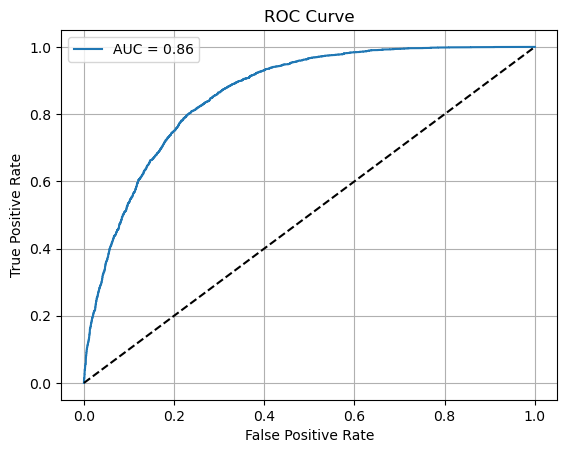

In [30]:
# ROC Curve + AUC (very helpful for binary classification)
# Probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


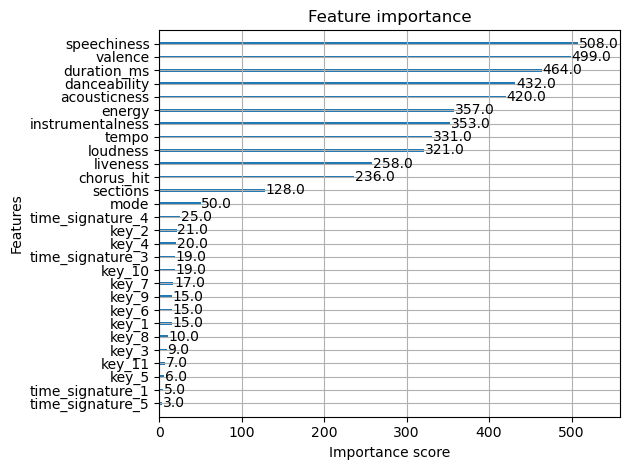

In [32]:
# Feature importance
xgb.plot_importance(model)
plt.tight_layout()
plt.show()


#### Now we perform grid searches to find the best hyperparameters for the features -> this optimises for best ROC AUC value


It should tell you:
Best ROC Score: 0.865

max_depth: 9 <br>
learning_rate: 0.1 <br>
n_estimators: 100 <br>
subsample: 0.8 <br>
colsample_bytree: 0.8 <br>

In [38]:
# Grid search ROC_AUC
param_grid = {
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    scoring='roc_auc',  # or 'accuracy'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


# Results
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}
Best AUC Score: 0.8648670191274663


#### Deeper tree and addition of subsample and colsample_bytree increased training accuracy ~8%, but only marginally increased the test accuracy by +0.0035% -> Overfitting

In [42]:
# Train XGBoost
model_roc = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=9,
    subsample = 0.8,
    colsample_bytree = 1.0,
    random_state=42,
    eval_metric='logloss'
)

model_roc.fit(X_train, y_train)


# Make a prediction
y_train_pred_roc = model_roc.predict(X_train)
y_test_pred_roc = model_roc.predict(X_test)

# Evaluate classification performance

# Overall accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_roc))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_roc))
print("")
# ROC AUC Score
y_test_proba_roc = model_roc.predict_proba(X_test)[:, 1]  # Probability of class 1
roc_auc_roc = roc_auc_score(y_test, y_test_proba_roc)
print("ROC AUC Score:", roc_auc_roc)
print("")
# Class-wise precision, recall, f1
print("Classification Report:\n", classification_report(y_test, y_test_pred_roc))

# TP, FP, FN, TN summary
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_roc))


Train Accuracy: 0.8961107001972387
Test Accuracy: 0.7846400394477318

ROC AUC Score: 0.8640620574675391

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78      4164
           1       0.75      0.84      0.79      3948

    accuracy                           0.78      8112
   macro avg       0.79      0.79      0.78      8112
weighted avg       0.79      0.78      0.78      8112

Confusion Matrix:
 [[3065 1099]
 [ 648 3300]]


###### Second grid search that widens the scope... WARNING: this takes a LONG time to get the results from and your laptop might sound like it's about to take-off 🛫

It should tell you: <br>
Best ROC Score: 0.869

max_depth: 9 <br>
learning_rate: 0.02 <br>
n_estimators: 600 <br>
subsample: 0.7 <br>
colsample_bytree: 0.8 <br>

In [44]:
# Grid search ROC_AUC
param_grid = {
    "max_depth": [5, 6, 7, 8, 9, 10],
    "learning_rate": [0.02, 0.05, 0.1],
    "n_estimators": [500, 600, 700],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best ROC Score:", grid_search.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 600, 'subsample': 0.8}
Best ROC Score: 0.8692971432114774


#### Several changes here to number of estimators, learning rate and sample rows... again increases the training accuracy ~3% on previous ROC model and ~11% on original model, but virtually no improvement in accuracy or ROC AUC -> Overfitting

In [47]:
# Train XGBoost
model_roc_2 = XGBClassifier(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=9,
    subsample = 0.7,
    colsample_bytree = 0.8,
    random_state=42,
    eval_metric='logloss'
)

model_roc_2.fit(X_train, y_train)


# Make a prediction
y_train_pred_roc_2 = model_roc_2.predict(X_train)
y_test_pred_roc_2 = model_roc_2.predict(X_test)

# Evaluate classification performance

# Overall accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_roc_2))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_roc_2))
print("")
# ROC AUC Score
y_test_proba_roc_2 = model_roc_2.predict_proba(X_test)[:, 1]  # Probability of class 1
roc_auc_roc_2 = roc_auc_score(y_test, y_test_proba_roc_2)
print("ROC AUC Score:", roc_auc_roc_2)
print("")
# Class-wise precision, recall, f1
print("Classification Report:\n", classification_report(y_test, y_test_pred_roc_2))

# TP, FP, FN, TN summary
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_roc_2))


Train Accuracy: 0.9125061637080868
Test Accuracy: 0.7863658777120316

ROC AUC Score: 0.8675142972961662

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78      4164
           1       0.75      0.84      0.79      3948

    accuracy                           0.79      8112
   macro avg       0.79      0.79      0.79      8112
weighted avg       0.79      0.79      0.79      8112

Confusion Matrix:
 [[3069 1095]
 [ 638 3310]]


#### Set-up comparative table

In [355]:
# Create an empty list to store results
model_results = []

# Define a helper function to extract metrics
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    model_results.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Accuracy Gap": abs(train_acc - test_acc),
        "ROC AUC": roc_auc_score(y_test, y_test_proba),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1 Score": f1_score(y_test, y_test_pred)
    })

# Add each model to the table
evaluate_model("Baseline Model", model, X_train, y_train, X_test, y_test)
evaluate_model("ROC Tuned Model", model_roc, X_train, y_train, X_test, y_test)
evaluate_model("ROC Tuned Model 2", model_roc_2, X_train, y_train, X_test, y_test)
evaluate_model("Log-Transformed Model", model_log, X_train_log, y_train, X_test_log, y_test)

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Sort and round for display
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False).round(3)

# Display results
print("\nModel Performance Comparison:")
display(
    results_df_sorted.style
    .highlight_max(subset=[col for col in results_df.columns if col not in ["Model", "Accuracy Gap"]], axis=0, color='lightgreen')
    .highlight_min(subset=["Accuracy Gap"], axis=0, color='lightgreen')
    .format({col: "{:.1%}" for col in results_df.columns if col != "Model"})
)



Model Performance Comparison:


#### Third grid search... this one has the same parameters as the previous but this one is looking to optimise Accuracy

It should tell you:
Best Accuracy: 0.79

max_depth: 9 <br>
learning_rate: 0.02 <br>
n_estimators: 700 <br>
subsample: 0.6 <br>
colsample_bytree: 0.8 <br>

In [65]:
# Grid search Accuracy
param_grid = {
    "max_depth": [5, 6, 7, 8, 9, 10],
    "learning_rate": [0.02, 0.05, 0.1],
    "n_estimators": [500, 600, 700],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 9, 'n_estimators': 700, 'subsample': 0.6}
Best Accuracy: 0.7903415831604083


####  Building a model from the recommended parameters... should match the results from above

#### This shows OVERFITTING

Train accuracy: 92.5% <br>
Test accuracy: 78.4% <br>

Difference: 14.1%

In [68]:
# Train XGBoost
model_acc = XGBClassifier(
    n_estimators=700,
    learning_rate=0.02,
    max_depth=9,
    subsample = 0.6,
    colsample_bytree = 0.8,
    random_state=42,
    eval_metric='logloss'
)

model_acc.fit(X_train, y_train)


# Make a prediction
y_train_pred_acc = model_acc.predict(X_train)
y_test_pred_acc = model_acc.predict(X_test)

# Evaluate classification performance

# Overall accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_acc))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_acc))
print("")
# ROC AUC Score
y_test_proba_acc = model_acc.predict_proba(X_test)[:, 1]  # Probability of class 1
roc_auc_acc = roc_auc_score(y_test, y_test_proba_acc)
print("ROC AUC Score:", roc_auc_roc_2)
print("")
# Class-wise precision, recall, f1
print("Classification Report:\n", classification_report(y_test, y_test_pred_acc))

# TP, FP, FN, TN summary
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_acc))


Train Accuracy: 0.9250184911242604
Test Accuracy: 0.7840236686390533

ROC AUC Score: 0.8675142972961662

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78      4164
           1       0.75      0.83      0.79      3948

    accuracy                           0.78      8112
   macro avg       0.79      0.79      0.78      8112
weighted avg       0.79      0.78      0.78      8112

Confusion Matrix:
 [[3070 1094]
 [ 658 3290]]


In [357]:
# Update results comparison table
evaluate_model("Accuracy Tuned Model", model_acc, X_train, y_train, X_test, y_test)

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Sort and round for display
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False).round(4)

# Display results
print("\nModel Performance Comparison:")
display(
    results_df_sorted.style
    .highlight_max(subset=[col for col in results_df.columns if col not in ["Model", "Accuracy Gap"]], axis=0, color='lightgreen')
    .highlight_min(subset=["Accuracy Gap"], axis=0, color='lightgreen')
    .format({col: "{:.1%}" for col in results_df.columns if col != "Model"})
)



Model Performance Comparison:


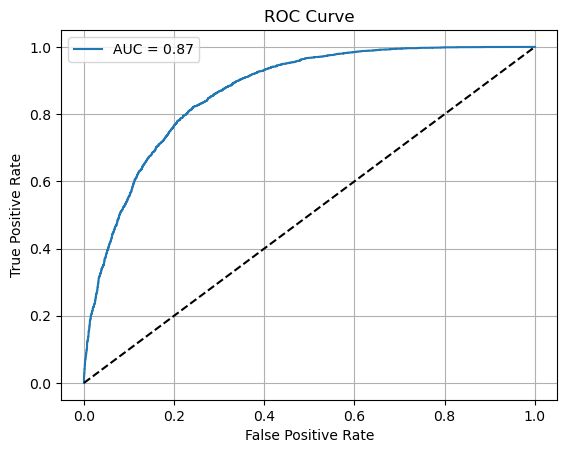

In [71]:
# ROC Curve + AUC (very helpful for binary classification)
# Probabilities for the positive class
y_prob_acc = model_acc.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_acc)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_acc):.2f}")
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


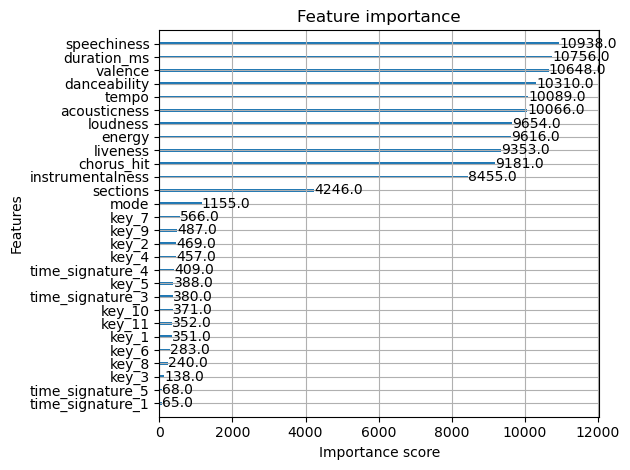

In [73]:
# Feature importance
xgb.plot_importance(model_acc)
plt.tight_layout()
plt.show()


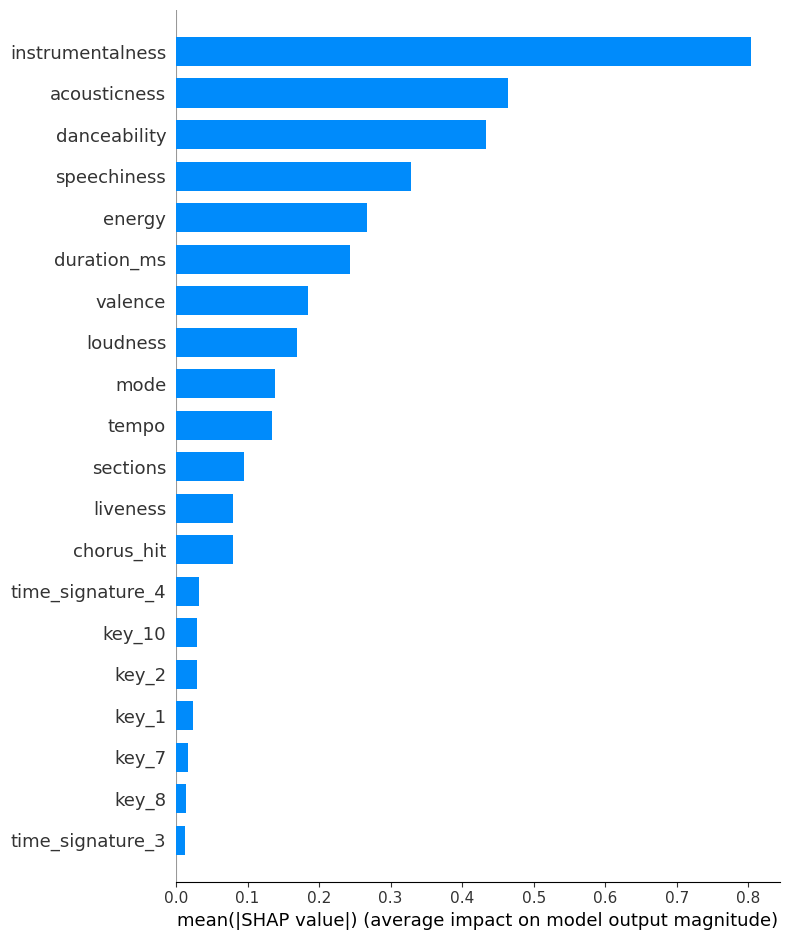

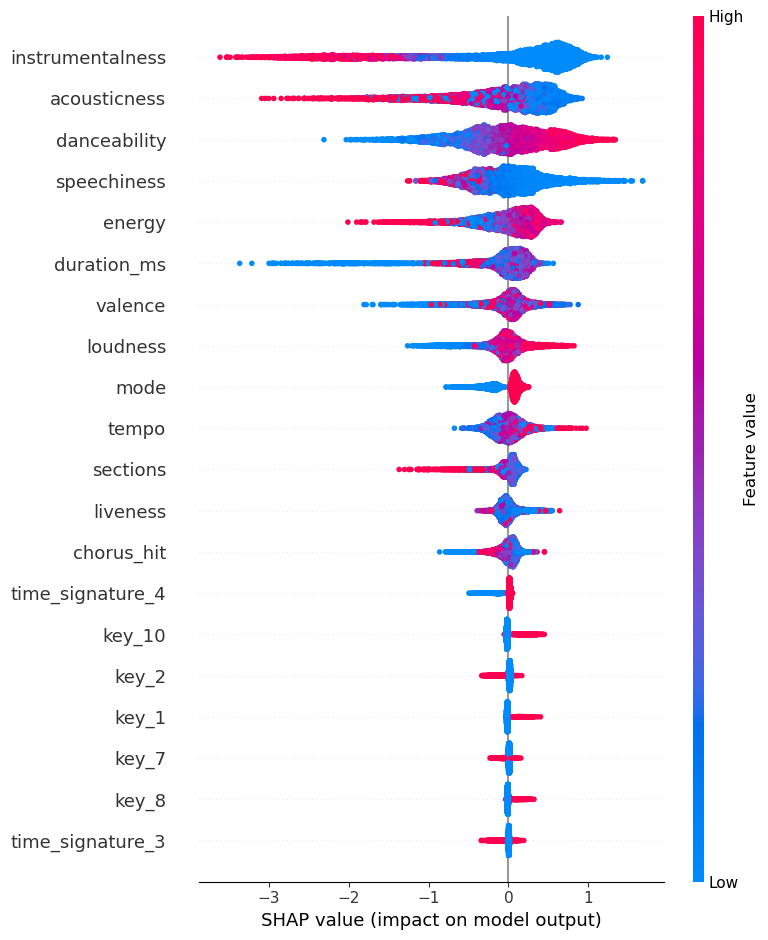

In [185]:
# Use TreeExplainer
explainer = shap.TreeExplainer(model_acc)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Bar plot of global importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Beeswarm plot (shows distribution and direction of impact)
shap.summary_plot(shap_values, X_test)


#### 4th grid search this time ADDING in alpha, lambda and gamma hyperparameters (Regularisation)... WARNING this one takes a REALLY long time

It should tell you: <br>
Best Accuracy: 0.789 <br>

max_depth: 7 <br>
learning_rate: 0.05 <br>
n_estimators: 300 <br>
subsample: 0.8 <br>
colsample_bytree: 0.8 <br>
reg_alpha: 0.5 <br>
reg_lambda: 1 <br>
gamma: 0.1 <br>

In [77]:
# Grid search Accuracy
param_grid = {
    "max_depth": [4, 5, 6, 7],
    "learning_rate": [0.02, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0.5, 1, 2],
    "gamma": [0, 0.1, 0.2]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.8}
Best Accuracy: 0.7885540945076901


In [79]:
# Make a prediction
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)

# Overall accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_best))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_best))
print("")
# ROC AUC Score
y_test_proba_best = best_model.predict_proba(X_test)[:, 1]  # Probability of class 1
roc_auc_best = roc_auc_score(y_test, y_test_proba_best)
print("ROC AUC Score:", roc_auc_best)
print("")
# Class-wise precision, recall, f1
print("Classification Report:\n", classification_report(y_test, y_test_pred_best))

# TP, FP, FN, TN summary
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_best))


Train Accuracy: 0.865538708086785
Test Accuracy: 0.7882149901380671

ROC AUC Score: 0.8678488883341265

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78      4164
           1       0.75      0.84      0.79      3948

    accuracy                           0.79      8112
   macro avg       0.79      0.79      0.79      8112
weighted avg       0.79      0.79      0.79      8112

Confusion Matrix:
 [[3074 1090]
 [ 628 3320]]


In [359]:
# Update results comparison table
evaluate_model("Regularised Model", best_model, X_train, y_train, X_test, y_test)

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Sort and round for display
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False).round(4)

# Display results
print("\nModel Performance Comparison:")
display(
    results_df_sorted.style
    .highlight_max(subset=[col for col in results_df.columns if col not in ["Model", "Accuracy Gap"]], axis=0, color='lightgreen')
    .highlight_min(subset=["Accuracy Gap"], axis=0, color='lightgreen')
    .format({col: "{:.1%}" for col in results_df.columns if col != "Model"})
)



Model Performance Comparison:


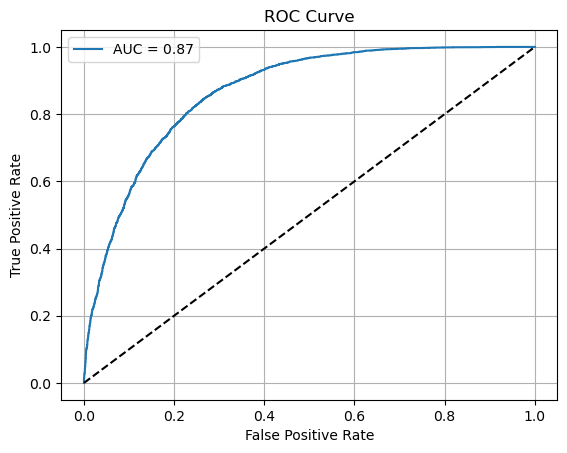

In [81]:
# ROC Curve + AUC (very helpful for binary classification)
# Probabilities for the positive class
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_best):.2f}")
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


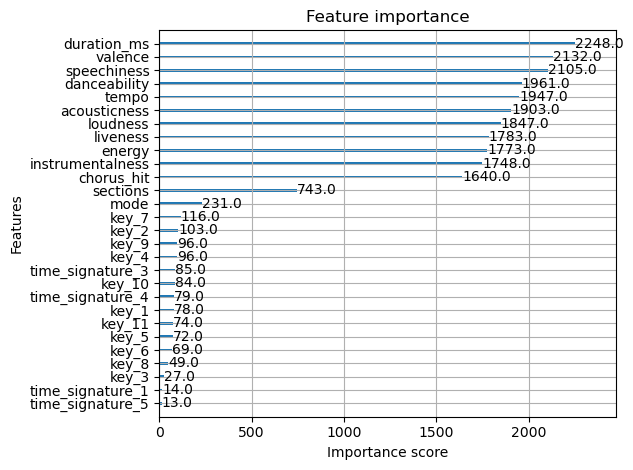

In [83]:
# Feature importance
xgb.plot_importance(best_model)
plt.tight_layout()
plt.show()


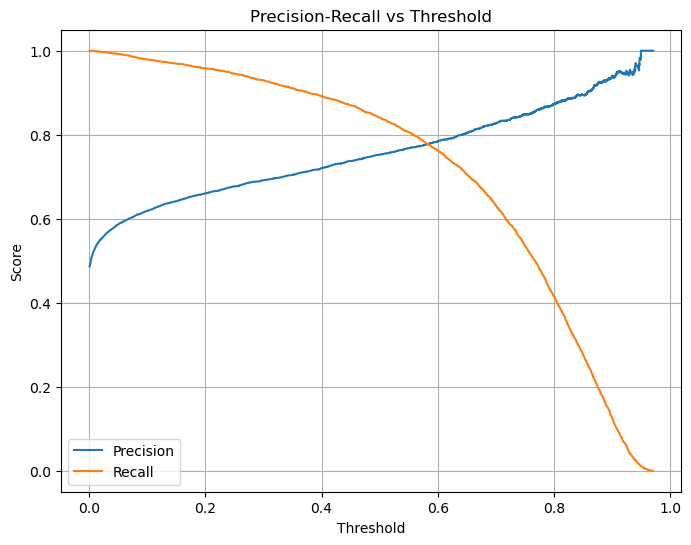

Optimal Threshold: 0.49467793
New Accuracy: 0.7887080867850098


In [85]:
# Threshold tuning

# Get probability predictions for positive class
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the precision-recall tradeoff
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_prob)

j_scores = tpr - fpr
best_thresh = thresholds[j_scores.argmax()]
print("Optimal Threshold:", best_thresh)

# Apply new threshold
y_test_pred_custom = (y_prob >= best_thresh).astype(int)
print("New Accuracy:", accuracy_score(y_test, y_test_pred_custom))



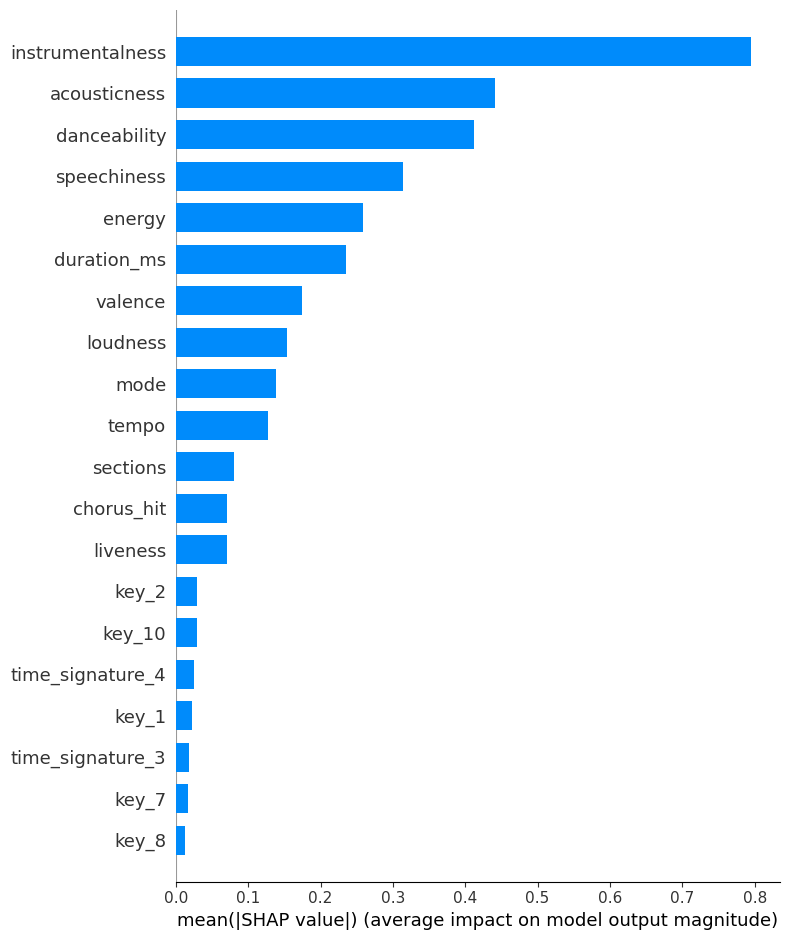

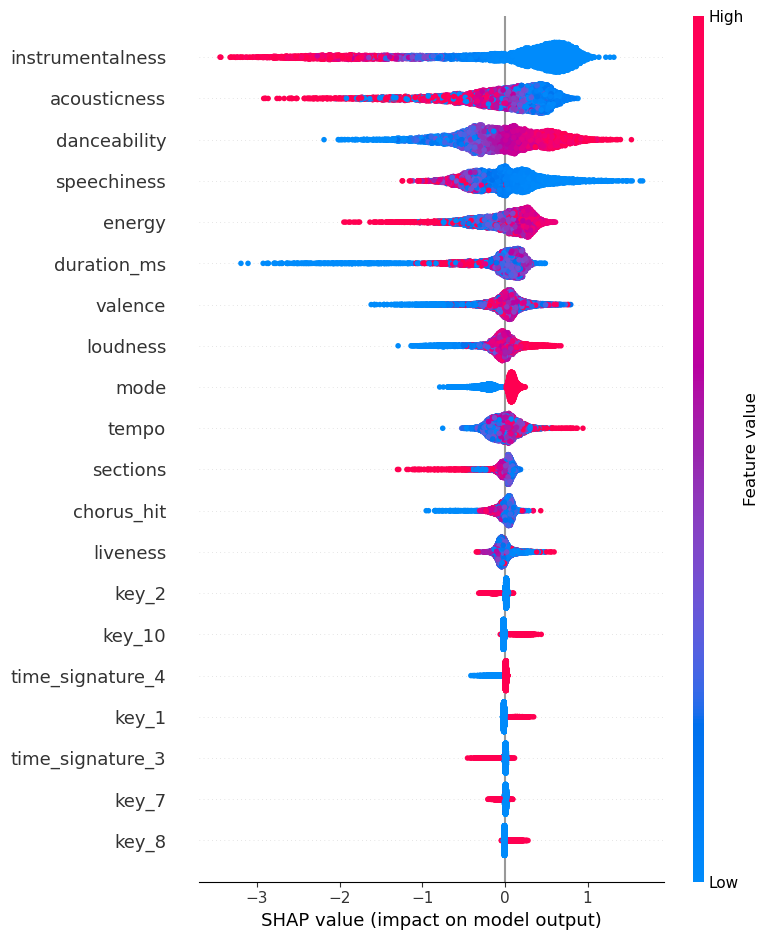

In [187]:
# Use TreeExplainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Bar plot of global importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Beeswarm plot (shows distribution and direction of impact)
shap.summary_plot(shap_values, X_test)


#  Next Steps To Try

## Permutation Importance

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


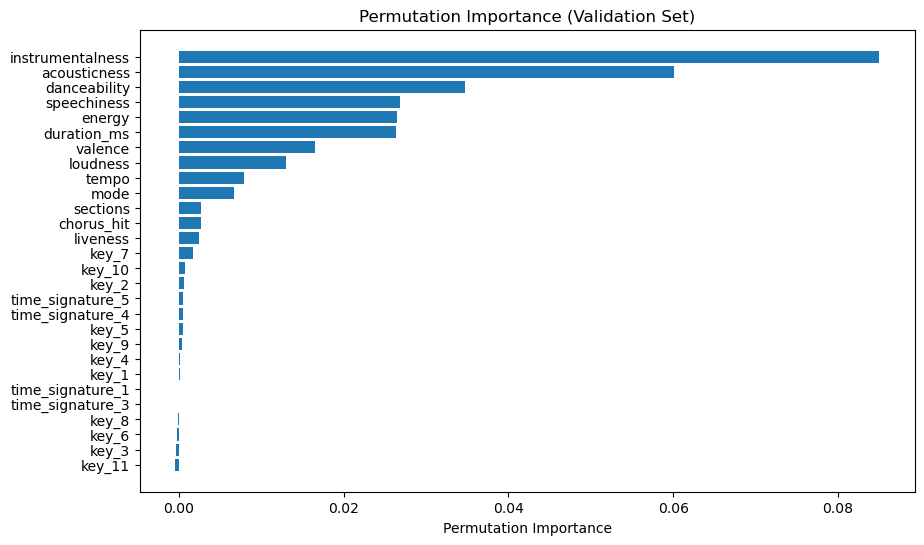

In [89]:
# Investigate permutations of features
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance (Validation Set)")
plt.gca().invert_yaxis()
plt.show()


In [91]:
# Investigate permutations of features using 'accuracy'
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, scoring='accuracy', random_state=42)

# Show top features
import pandas as pd
sorted_idx = result.importances_mean.argsort()[::-1]
pd.DataFrame({
    "Feature": X_test.columns[sorted_idx],
    "Importance": result.importances_mean[sorted_idx],
    "Std": result.importances_std[sorted_idx]
})


Feature  Importance       Std
0   instrumentalness    0.085022  0.001522
1       acousticness    0.060145  0.002372
2       danceability    0.034776  0.001988
3        speechiness    0.026861  0.002513
4             energy    0.026430  0.001322
5        duration_ms    0.026344  0.002626
6            valence    0.016531  0.002414
7           loudness    0.013018  0.001976
8              tempo    0.007877  0.001374
9               mode    0.006669  0.001332
10          sections    0.002761  0.000898
11        chorus_hit    0.002737  0.001651
12          liveness    0.002453  0.001179
13             key_7    0.001763  0.000455
14            key_10    0.000703  0.000602
15             key_2    0.000629  0.000743
16  time_signature_5    0.000555  0.000177
17  time_signature_4    0.000505  0.000644
18             key_5    0.000493  0.000401
19             key_9    0.000456  0.000349
20             key_4    0.000185  0.000229
21             key_1    0.000173  0.000481
22  time_signature_1    0.000086  0.000166
23  time_signature_3    0.000037  0.000734
24             key_8   -0.000074  0.000421
25             key_6   -0.000222  0.000334
26             key_3   -0.000357  0.000243
27            key_11   -0.000456  0.000146

## Recursive Feature Elimination (RFE)

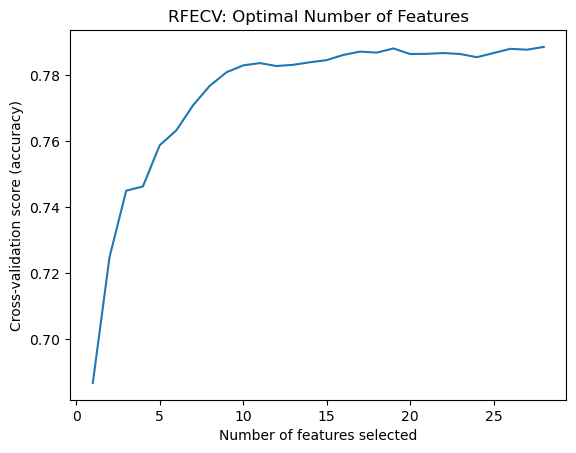

Selected Features: ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'sections', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']


In [93]:
# Re-instantiate model using best parameters
best_params = best_model.get_params()
base_estimator = XGBClassifier(**best_params)

# Run RFECV
rfecv = RFECV(
    estimator=base_estimator,
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

# Plot results
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'])
plt.title("RFECV: Optimal Number of Features")
plt.show()

# View selected features
selected_features = X_train.columns[rfecv.support_]
print("Selected Features:", list(selected_features))


In [95]:
# RFE ranking
rfe = RFE(base_estimator, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

print("Selected features:", X_train.columns[rfe.support_])
print("Ranking of all features:", rfe.ranking_)


Selected features: Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'valence', 'duration_ms',
       'time_signature_4'],
      dtype='object')
Ranking of all features: [ 1  1  1  1  1  1  1 10  1  6  1 12  4  7  5 19 17 16 15  9 11 13  3 18
  8  2  1 14]


# Dropping features - Retaining only those identified by REF

In [99]:
spotify_df.columns

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'chorus_hit', 'sections', 'on_billboard', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

In [103]:
# Identifying which features to drop
columns_to_drop = [
    "liveness", "tempo", "sections", "chorus_hit", "key_1", "key_2", "key_3", "key_4",
    "key_5", "key_6", "key_7", "key_8", "key_9", "key_10", "key_11", "time_signature_1",
    "time_signature_3", "time_signature_5"
]

# Modifying the original Train-Test Split
X_train_reduced = X_train.drop(columns=columns_to_drop)
X_test_reduced = X_test.drop(columns=columns_to_drop)


#### 5th grid search BUT this one is on the reduced feature set... WARNING this one also takes FOREVER... 💀🪦

It should tell you: <br>
Best Accuracy: 0.785

max_depth: 7 <br>
learning_rate: 0.05 <br>
n_estimators: 200 <br>
subsample: 0.6 <br>
colsample_bytree: 0.8 <br>
reg_alpha: 0.5 <br>
reg_lambda: 1 <br>
gamma: 0 <br>

In [105]:
# Grid search Accuracy
param_grid = {
    "max_depth": [4, 5, 6, 7],
    "learning_rate": [0.02, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0.5, 1, 2],
    "gamma": [0, 0.1, 0.2]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_reduced, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.6}
Best Accuracy: 0.7852563814880748


In [117]:
# Fit the best estimators from grid search
reduced_model = grid_search.best_estimator_
reduced_model.fit(X_train_reduced, y_train)

y_test_pred_reduced = reduced_model.predict(X_test_reduced)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred_reduced))
print(classification_report(y_test, y_test_pred_reduced))


Test Accuracy: 0.7811883629191322
              precision    recall  f1-score   support

           0       0.83      0.73      0.77      4164
           1       0.74      0.84      0.79      3948

    accuracy                           0.78      8112
   macro avg       0.79      0.78      0.78      8112
weighted avg       0.79      0.78      0.78      8112



In [119]:
# Make a prediction
y_train_pred_reduced = reduced_model.predict(X_train_reduced)

# Overall accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_reduced))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_reduced))
print("")

# ROC AUC Score
y_test_proba_reduced = reduced_model.predict_proba(X_test_reduced)[:, 1]  # Probability of class 1
roc_auc_reduced = roc_auc_score(y_test, y_test_proba_reduced)
print("ROC AUC Score:", roc_auc_reduced)
print("")

# Class-wise precision, recall, f1
print("Classification Report:\n", classification_report(y_test, y_test_pred_reduced))

# TP, FP, FN, TN summary
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_reduced))


Train Accuracy: 0.8288338264299803
Test Accuracy: 0.7811883629191322

ROC AUC Score: 0.8604786394599534

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.73      0.77      4164
           1       0.74      0.84      0.79      3948

    accuracy                           0.78      8112
   macro avg       0.79      0.78      0.78      8112
weighted avg       0.79      0.78      0.78      8112

Confusion Matrix:
 [[3020 1144]
 [ 631 3317]]


In [361]:
# Update results comparison table
evaluate_model("Reduced Feature Model", reduced_model, X_train_reduced, y_train, X_test_reduced, y_test)

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Sort and round for display
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False).round(4)

# Display results
print("\nModel Performance Comparison:")
display(
    results_df_sorted.style
    .highlight_max(subset=[col for col in results_df.columns if col not in ["Model", "Accuracy Gap"]], axis=0, color='lightgreen')
    .highlight_min(subset=["Accuracy Gap"], axis=0, color='lightgreen')
    .format({col: "{:.1%}" for col in results_df.columns if col != "Model"})
)



Model Performance Comparison:


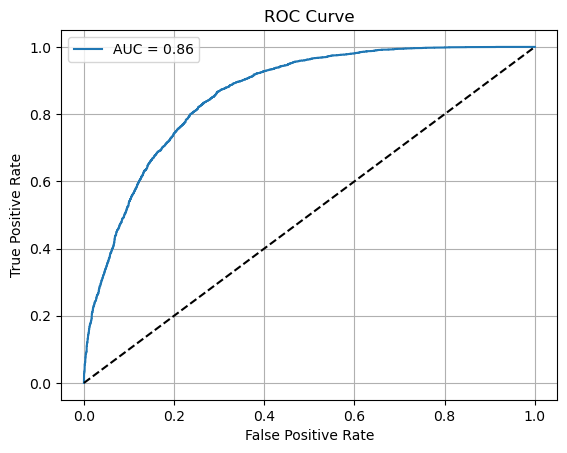

In [125]:
# ROC Curve + AUC (very helpful for binary classification)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_reduced)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_proba_reduced):.2f}")
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


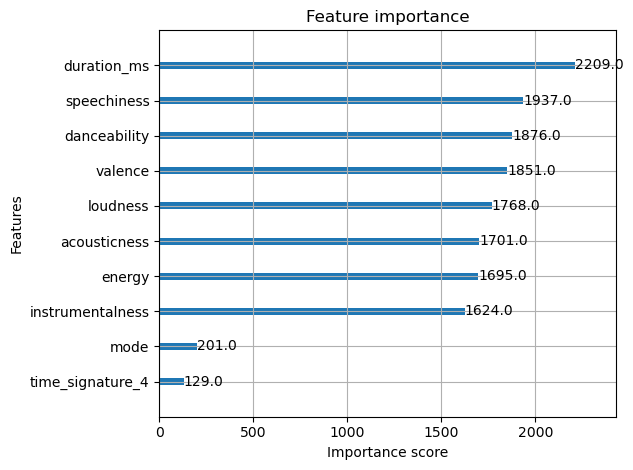

In [127]:
# Feature importance
xgb.plot_importance(reduced_model)
plt.tight_layout()
plt.show()


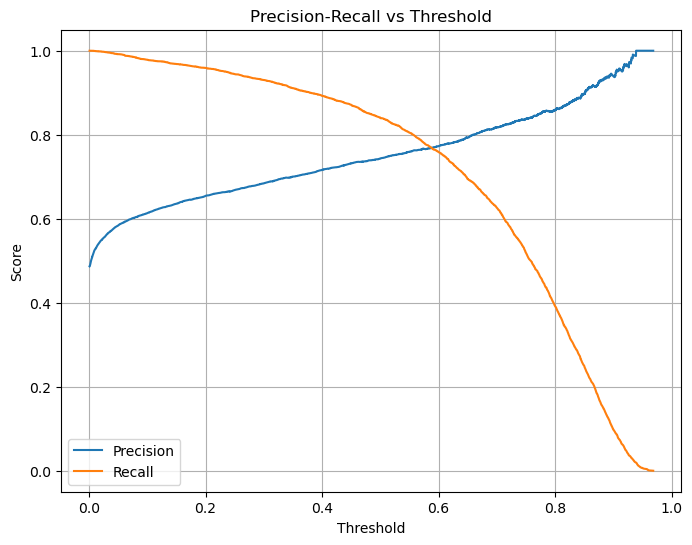

In [129]:
# Threshold tuning

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba_reduced)

# Plot the precision-recall tradeoff
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()


In [131]:
# Optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_reduced)
j_scores = tpr - fpr
best_thresh_reduced = thresholds[j_scores.argmax()]
print("Optimal Threshold:", best_thresh_reduced)

# Apply
y_test_pred_custom_reduced = (y_test_proba_reduced >= best_thresh_reduced).astype(int)


Optimal Threshold: 0.45855173


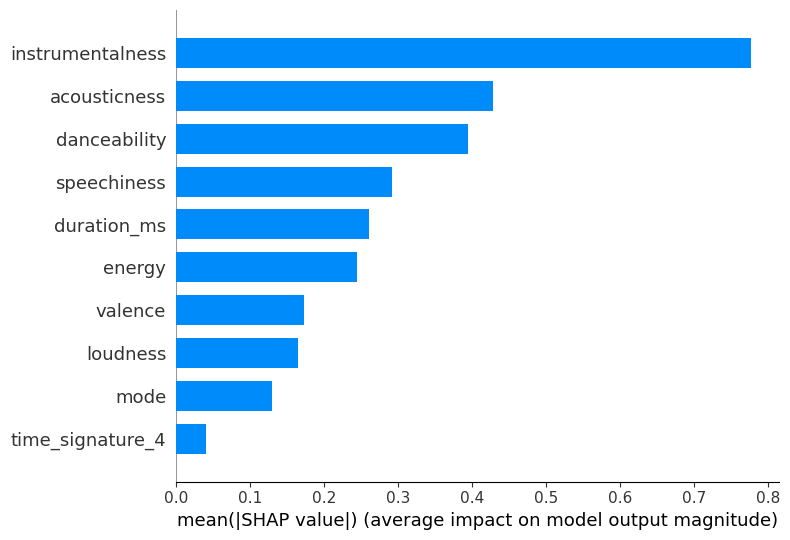

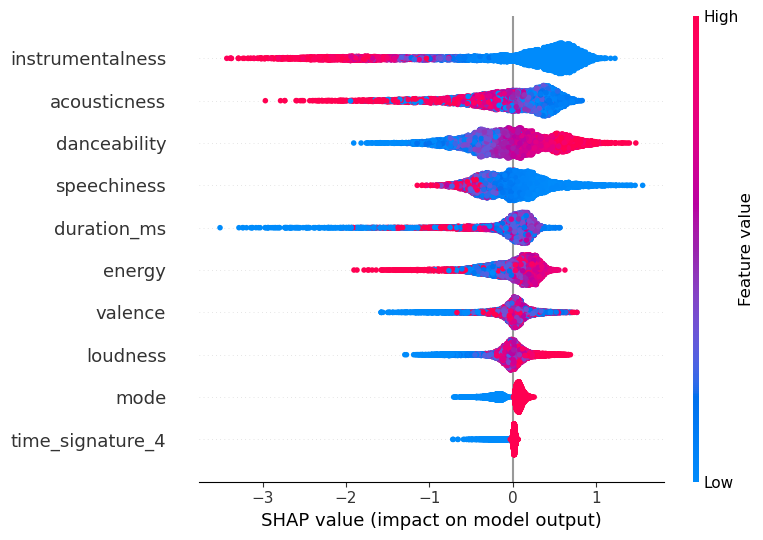

In [193]:
# Use TreeExplainer instead of the general Explainer (bypasses torch + CUDA)
explainer = shap.TreeExplainer(reduced_model)

# Compute SHAP values
shap_values_reduced = explainer.shap_values(X_test_reduced)

# Bar plot of global importance
shap.summary_plot(shap_values_reduced, X_test_reduced, plot_type="bar")

# Beeswarm plot (shows distribution and direction of impact)
shap.summary_plot(shap_values_reduced, X_test_reduced)


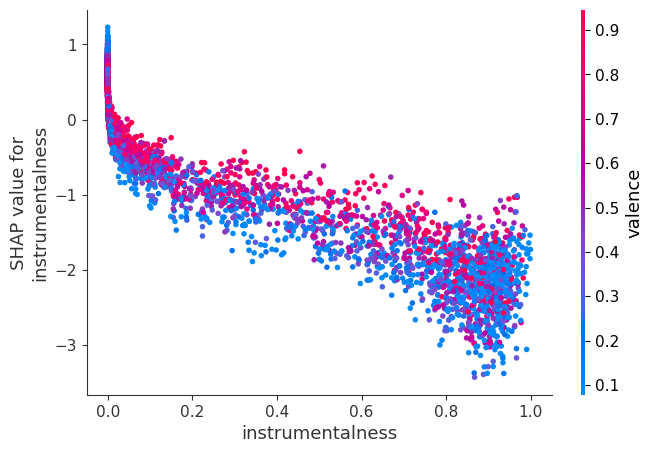

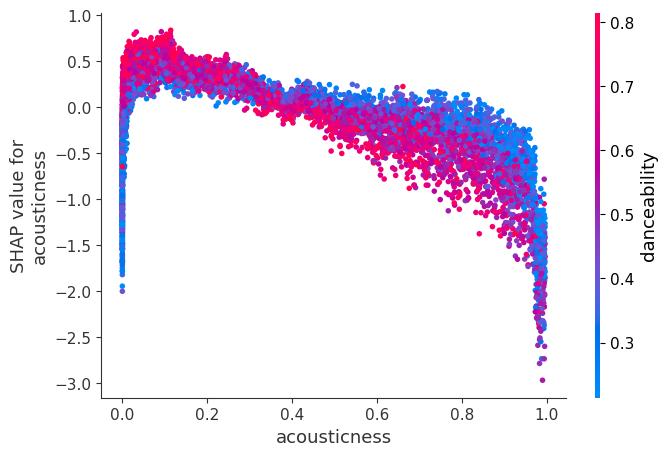

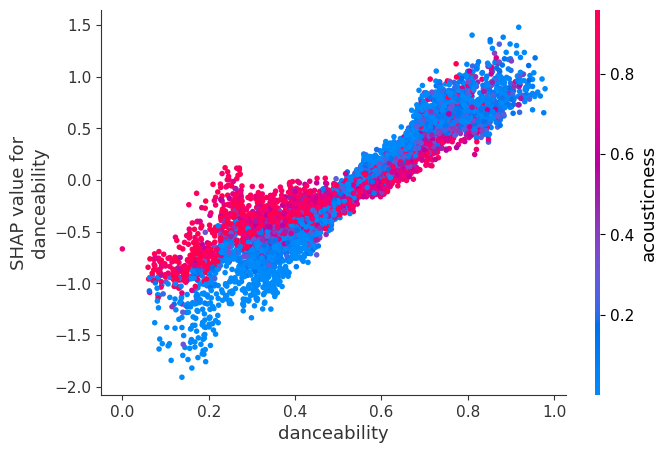

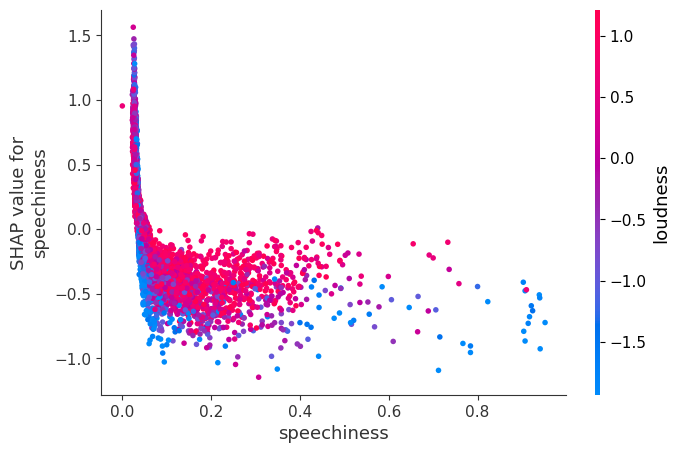

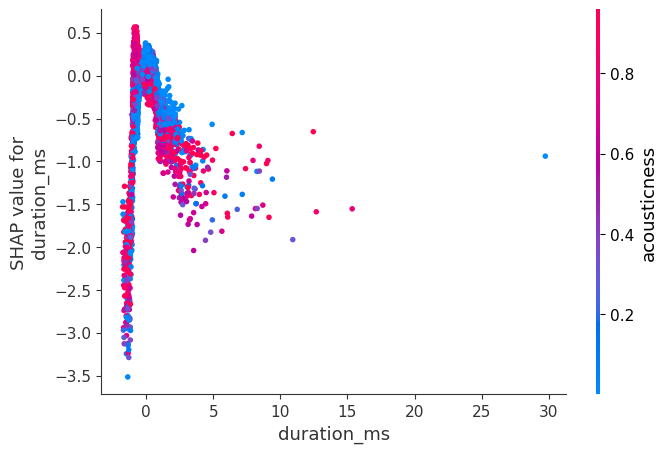

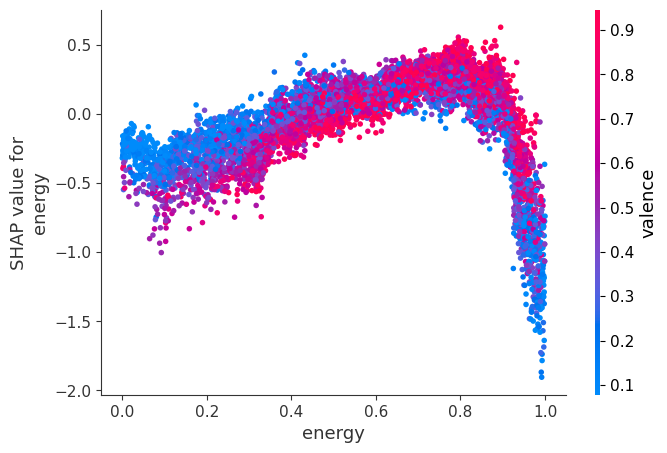

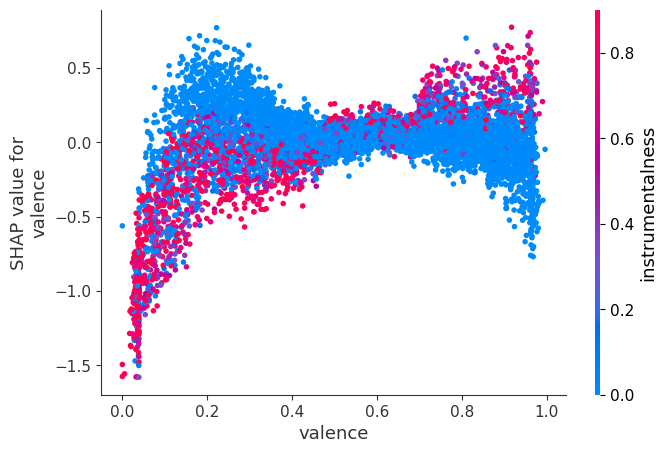

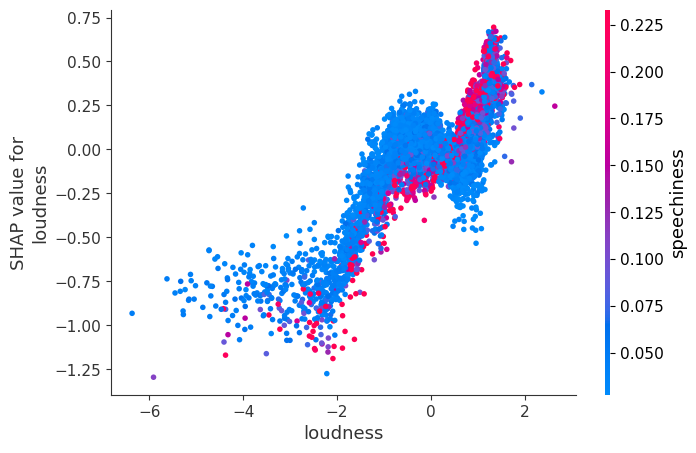

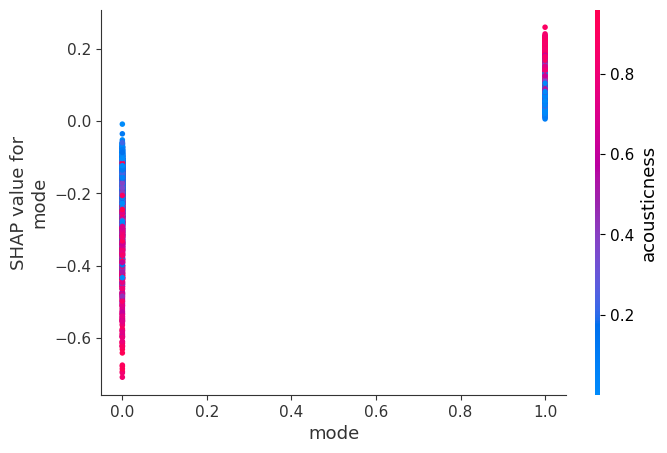

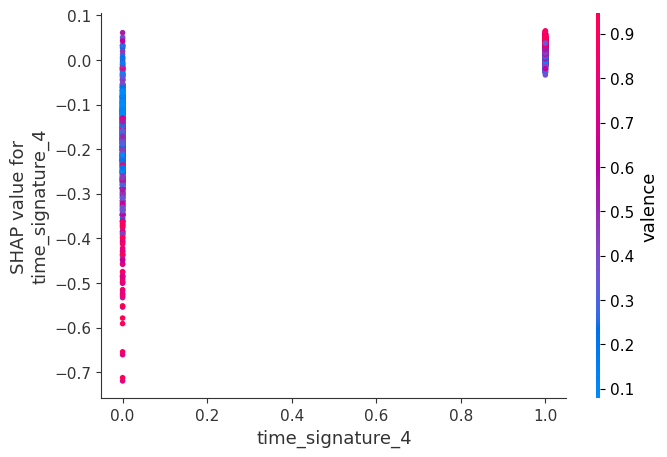

In [195]:
# SHAP Dependence plots for hit zone discovery
for feature in [
    "instrumentalness", "acousticness", "danceability", "speechiness",
    "duration_ms", "energy", "valence", "loudness", "mode", "time_signature_4"
]:
    shap.dependence_plot(feature, shap_values_reduced, X_test_reduced, show=True)


In [141]:
print("Custom Accuracy:", accuracy_score(y_test, y_test_pred_custom_reduced))
print("")
# ROC AUC
print("Custom ROC AUC:", roc_auc_score(y_test, y_test_proba_reduced)) 
print("")
# Class-wise precision, recall, f1
print("Classification Report:\n", classification_report(y_test, y_test_pred_custom_reduced))

# TP, FP, FN, TN summary
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_custom_reduced))


Custom Accuracy: 0.7830374753451677

Custom ROC AUC: 0.8604786394599534

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77      4164
           1       0.74      0.87      0.80      3948

    accuracy                           0.78      8112
   macro avg       0.79      0.79      0.78      8112
weighted avg       0.79      0.78      0.78      8112

Confusion Matrix:
 [[2931 1233]
 [ 527 3421]]


In [363]:
# Manually append custom threshold model
model_results.append({
    "Model": "Custom Threshold Model",
    "Train Accuracy": np.nan,
    "Test Accuracy": accuracy_score(y_test, y_test_pred_custom_reduced),
    "Accuracy Gap": np.nan,
    "ROC AUC": roc_auc_score(y_test, y_test_proba_reduced),
    "Precision": precision_score(y_test, y_test_pred_custom_reduced),
    "Recall": recall_score(y_test, y_test_pred_custom_reduced),
    "F1 Score": f1_score(y_test, y_test_pred_custom_reduced)
})

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Coerce all metric columns to numeric (safe even if they're already numeric)
#numeric_cols = ["Train Accuracy", "Test Accuracy", "ROC AUC", "Precision", "Recall", "F1 Score"]
#results_df[numeric_cols] = results_df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Re-sort AFTER adding the custom model
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False)

# Display the updated sorted DataFrame
print("\nModel Performance Comparison:")
display(
    results_df_sorted.style
    .highlight_max(subset=[col for col in results_df.columns if col not in ["Model", "Accuracy Gap"]], axis=0, color='lightgreen')
    .highlight_min(subset=["Accuracy Gap"], axis=0, color='lightgreen')
    .format({col: "{:.1%}" for col in results_df.columns if col != "Model"}, na_rep='–')
)



Model Performance Comparison:


#### Calibrate the model

In [205]:
# Calibrate the model
calibrated_model = CalibratedClassifierCV(reduced_model, method='isotonic', cv=10)
calibrated_model.fit(X_train_reduced, y_train)

# Get predicted probabilities (after calibration)
y_prob_calibrated = calibrated_model.predict_proba(X_test_reduced)[:, 1]

# Calculate best threshold from calibrated model
fpr_cal, tpr_cal, thresholds_cal = roc_curve(y_test, y_prob_calibrated)
j_scores_cal = tpr_cal - fpr_cal
best_thresh_calibrated = thresholds_cal[j_scores_cal.argmax()]

# Apply new threshold
y_test_pred_custom_calibrated = (y_prob_calibrated >= best_thresh_calibrated).astype(int)

# Now evaluate using the calibrated predictions
print("Calibrated Accuracy:", accuracy_score(y_test, y_test_pred_custom_calibrated))
print("Calibrated AUC:", roc_auc_score(y_test, y_prob_calibrated))
print("Classification Report:\n", classification_report(y_test, y_test_pred_custom_calibrated))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_custom_calibrated))


Calibrated Accuracy: 0.7815581854043393
Calibrated AUC: 0.8620424670573361
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78      4164
           1       0.76      0.81      0.78      3948

    accuracy                           0.78      8112
   macro avg       0.78      0.78      0.78      8112
weighted avg       0.78      0.78      0.78      8112

Confusion Matrix:
 [[3155 1009]
 [ 763 3185]]


In [365]:
# Append calibrated model results to the list
model_results.append({
    "Model": "Calibrated + Custom Threshold",
    "Train Accuracy": np.nan,
    "Test Accuracy": accuracy_score(y_test, y_test_pred_custom_calibrated),
    "Accuracy Gap": np.nan,
    "ROC AUC": roc_auc_score(y_test, y_prob_calibrated),
    "Precision": precision_score(y_test, y_test_pred_custom_calibrated),
    "Recall": recall_score(y_test, y_test_pred_custom_calibrated),
    "F1 Score": f1_score(y_test, y_test_pred_custom_calibrated)
})


# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Coerce all metric columns to numeric (safe even if they're already numeric)
#numeric_cols = ["Train Accuracy", "Test Accuracy", "ROC AUC", "Precision", "Recall", "F1 Score"]
#results_df[numeric_cols] = results_df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Re-sort AFTER adding the custom model
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False)

# Display the updated sorted DataFrame
print("\nModel Performance Comparison:")
display(
    results_df_sorted.style
    .highlight_max(subset=[col for col in results_df.columns if col not in ["Model", "Accuracy Gap"]], axis=0, color='lightgreen')
    .highlight_min(subset=["Accuracy Gap"], axis=0, color='lightgreen')
    .format({col: "{:.1%}" for col in results_df.columns if col != "Model"}, na_rep='–')
)



Model Performance Comparison:


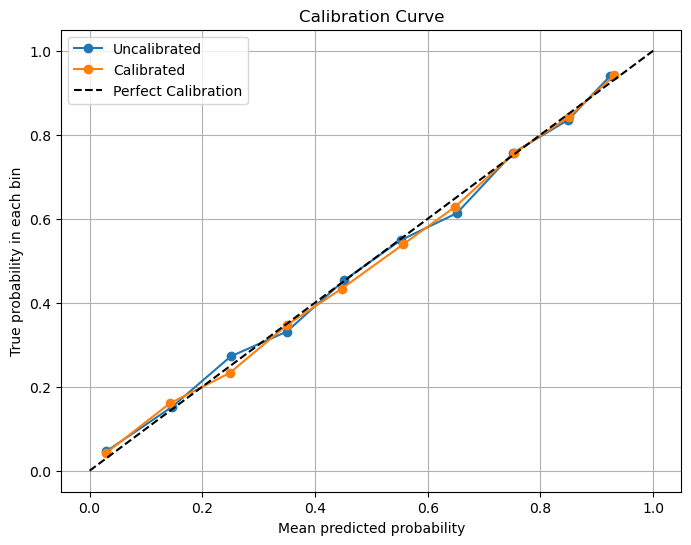

In [173]:
# Visually compare before and after calibration

# Uncalibrated probs
y_prob_raw = y_test_proba_reduced

# Calibration curve
prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_prob_raw, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred_raw, prob_true_raw, label="Uncalibrated", marker='o')
plt.plot(prob_pred_cal, prob_true_cal, label="Calibrated", marker='o')
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("True probability in each bin")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()


#### Brier Metrics

In [175]:
# Uncalibrated
brier_raw = brier_score_loss(y_test, y_test_proba_reduced)

# Calibrated
brier_cal = brier_score_loss(y_test, y_prob_calibrated)

print("Brier Score (Uncalibrated):", brier_raw)
print("Brier Score (Calibrated):", brier_cal)


Brier Score (Uncalibrated): 0.15056113324766385
Brier Score (Calibrated): 0.14985910861644464


#### Clustering

In [177]:
# Cluster High-Scoring Predicted Hits

# Get high-scoring tracks (probability > threshold)
hit_candidates = X_test_reduced[y_prob_calibrated >= best_thresh].copy()

# Standardize features
scaler = StandardScaler()
hit_scaled = scaler.fit_transform(hit_candidates)

# Cluster (tune n_clusters based on silhouette score if needed)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(hit_scaled)
hit_candidates['cluster'] = clusters

# Analyze clusters
hit_cluster_summary = hit_candidates.groupby('cluster').mean()
hit_cluster_summary


danceability    energy  loudness      mode  speechiness  \
cluster                                                            
0            0.664574  0.696595  0.440955  0.000000     0.058212   
1            0.627290  0.715957  0.487730  1.000000     0.050695   
2            0.746199  0.686069  0.662013  0.581717     0.288911   
3            0.497516  0.406636 -0.208547  0.915612     0.036449   

         acousticness  instrumentalness   valence  duration_ms  \
cluster                                                          
0            0.165702          0.014825  0.671562     0.034481   
1            0.176873          0.016796  0.688294    -0.066904   
2            0.120479          0.002189  0.585372     0.005634   
3            0.569260          0.002776  0.490829    -0.327726   

         time_signature_4  
cluster                    
0                0.984536  
1                0.992114  
2                0.955679  
3                0.806751

## Exploring interaction effects

#### Key Insight: With low interaction strengths, your model is likely dominated by main effects. The interactions you're seeing are subtle modifiers rather than strong joint effects.

Model's expected feature order: ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'duration_ms', 'time_signature_4']


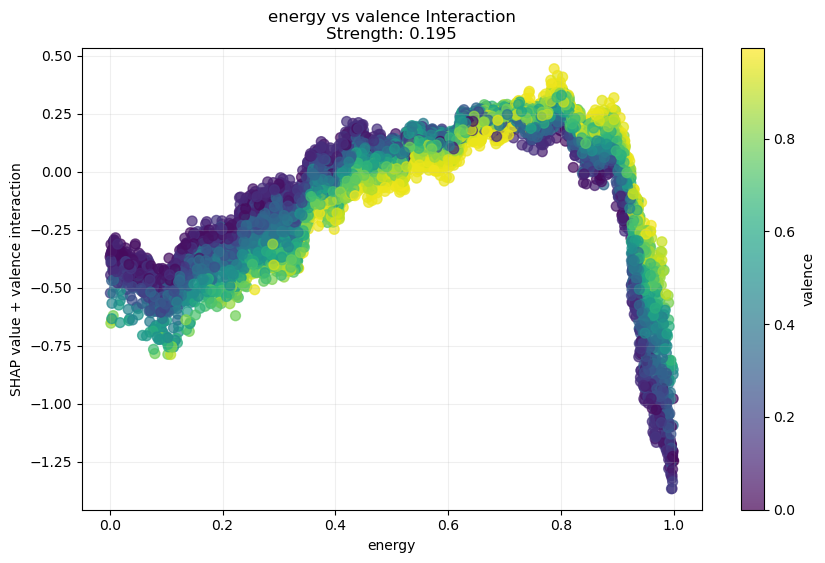

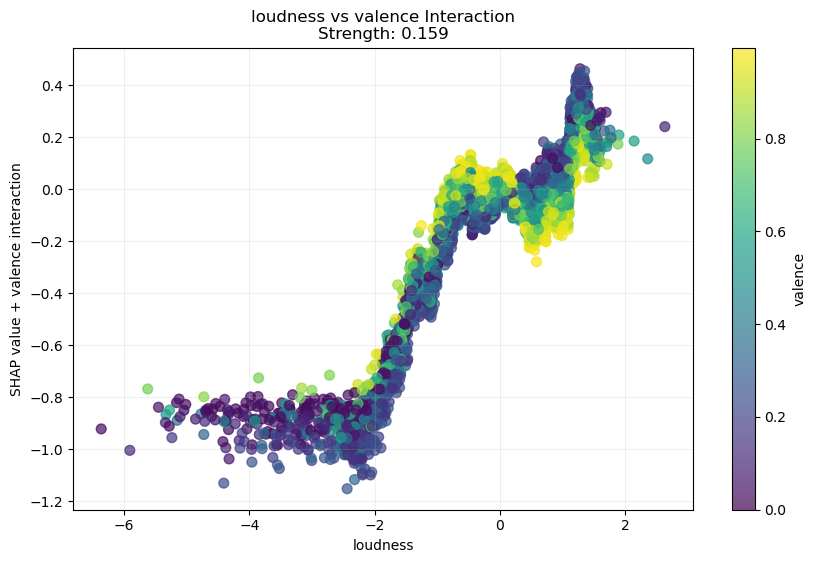

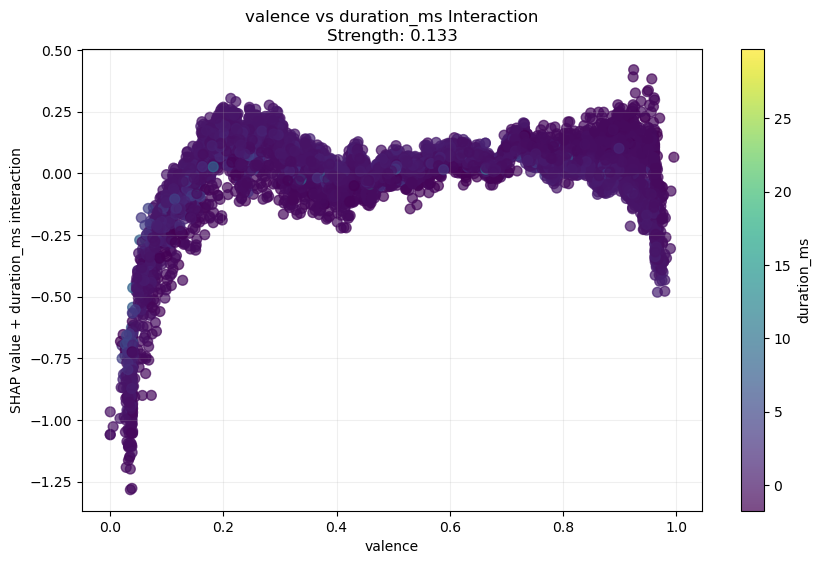

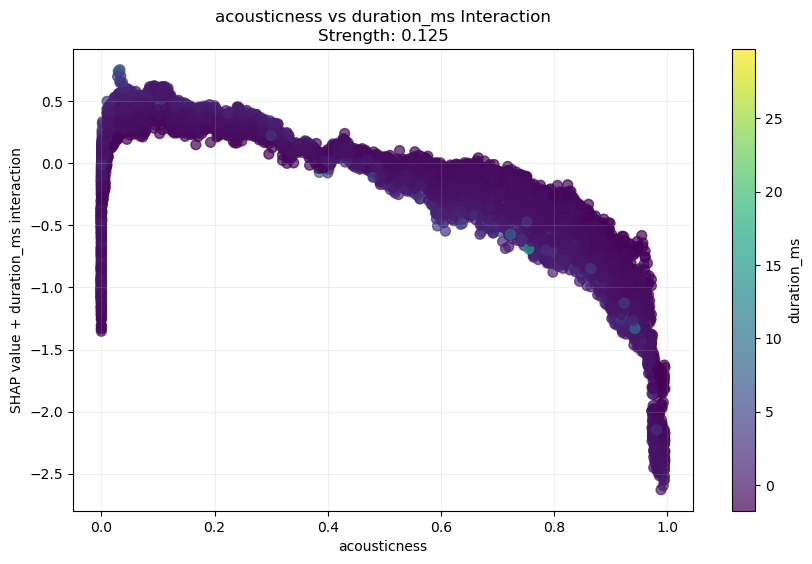

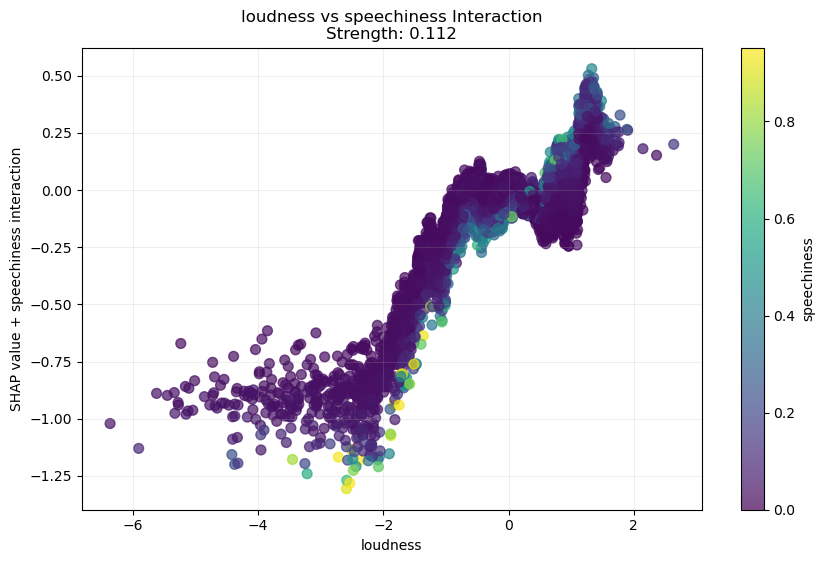

In [212]:
# Prepare for PCA

# Get CORRECT feature order from the trained model
correct_feature_order = reduced_model.get_booster().feature_names
print("Model's expected feature order:", correct_feature_order)

# Prepare data with EXACT matching order
X_top = X_test_reduced[correct_feature_order].copy()

# Create SHAP explainer (now using properly ordered features)
explainer = shap.TreeExplainer(reduced_model)
shap_interaction_values = explainer.shap_interaction_values(X_top)
shap_interaction_values = np.array(shap_interaction_values)

# For binary classification: take class 1's interactions
if len(shap_interaction_values.shape) == 4:  # Multi-class format
    shap_interaction_values = shap_interaction_values[1]

# Calculate interaction strengths (with correct indices)
interaction_strengths = []
for i, j in combinations(range(len(correct_feature_order)), 2):
    feat1, feat2 = correct_feature_order[i], correct_feature_order[j]
    interaction_matrix = np.abs(shap_interaction_values[:,i,j]).mean()
    main_effect_i = np.abs(shap_interaction_values[:,i,i]).mean()
    main_effect_j = np.abs(shap_interaction_values[:,j,j]).mean()
    
    interaction_strengths.append({
        'Feature 1': feat1,
        'Feature 2': feat2,
        'Interaction Strength': interaction_matrix / (main_effect_i + main_effect_j),
        'Absolute Interaction': interaction_matrix
    })

interaction_df = pd.DataFrame(interaction_strengths)
interaction_df = interaction_df.sort_values('Interaction Strength', ascending=False)

# Visualize top interactions
top_interactions = interaction_df.head(5)  # Get top 5 strongest
for _, row in top_interactions.iterrows():
    feat1, feat2 = row['Feature 1'], row['Feature 2']
    try:
        idx1 = correct_feature_order.index(feat1)
        idx2 = correct_feature_order.index(feat2)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(
            X_top[feat1],
            shap_interaction_values[:,idx1,idx1] + shap_interaction_values[:,idx1,idx2],
            c=X_top[feat2],
            cmap='viridis',
            alpha=0.7,
            s=50
        )
        plt.colorbar(label=feat2)
        plt.xlabel(feat1)
        plt.ylabel(f"SHAP value + {feat2} interaction")
        plt.title(f"{feat1} vs {feat2} Interaction\nStrength: {row['Interaction Strength']:.3f}")
        plt.grid(True, alpha=0.2)
        plt.show()
        
    except Exception as e:
        print(f"❌ Failed to plot {feat1} vs {feat2}: {str(e)}")
        plt.close()


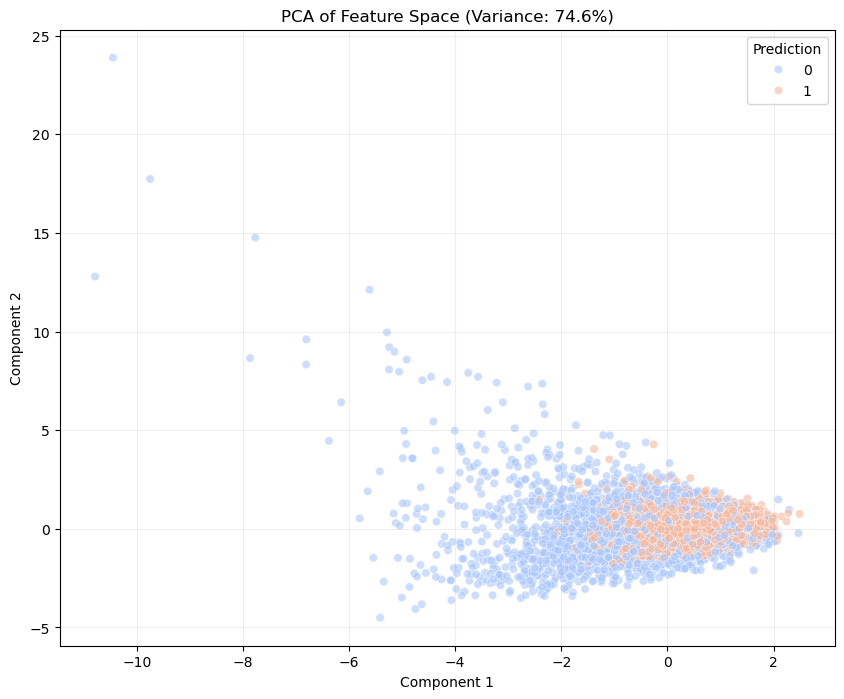

In [214]:
# Dimensionality reduction of Interaction features visualization (PCA)
X_interaction = X_top.copy()
for _, row in top_interactions.iterrows():
    feat1, feat2 = row['Feature 1'], row['Feature 2']
    X_interaction[f"{feat1}_x_{feat2}"] = X_interaction[feat1] * X_interaction[feat2]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_interaction)

plot_df = pd.DataFrame(X_pca, columns=['Component 1', 'Component 2'])
plot_df['Prediction'] = reduced_model.predict(X_top)  # Now using correctly ordered features

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=plot_df,
    x='Component 1',
    y='Component 2',
    hue='Prediction',
    palette='coolwarm',
    alpha=0.6
)
plt.title(f"PCA of Feature Space (Variance: {pca.explained_variance_ratio_.sum():.1%})")
plt.grid(True, alpha=0.2)
plt.show()


In [216]:
# Check how much variance they explain
print(pca.explained_variance_ratio_)


[0.38453138 0.36179665]


Original model features (10): ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'duration_ms', 'time_signature_4']
Added interaction terms (5): ['energy_x_valence', 'loudness_x_valence', 'valence_x_duration_ms', 'acousticness_x_duration_ms', 'loudness_x_speechiness']
Total PCA features (15): ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'duration_ms', 'time_signature_4', 'energy_x_valence', 'loudness_x_valence', 'valence_x_duration_ms', 'acousticness_x_duration_ms', 'loudness_x_speechiness']

Top features driving Principal Component 1:
                       Feature       PC1
2                     loudness  0.802996
8                  duration_ms -0.353191
11          loudness_x_valence  0.306865
13  acousticness_x_duration_ms -0.181991
1                       energy  0.158184
5                 acousticness -0.153010
12       valence_x_duration_ms -0.119557
10      

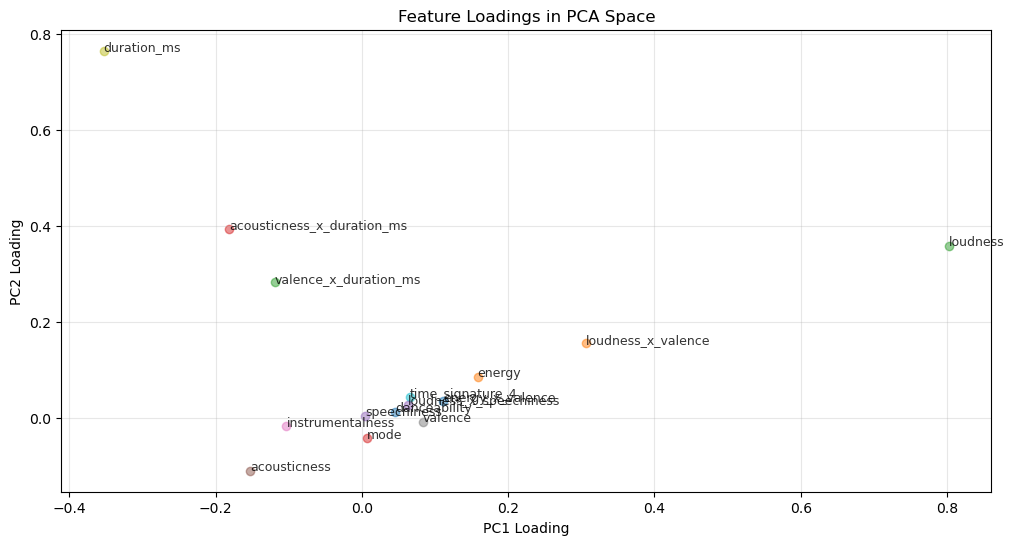

In [218]:
# Get the original model's feature order
correct_feature_order = reduced_model.get_booster().feature_names
print(f"Original model features ({len(correct_feature_order)}):", correct_feature_order)

# Create list of interaction terms from top interactions
interaction_terms = [f"{row['Feature 1']}_x_{row['Feature 2']}" for _, row in top_interactions.iterrows()]
print(f"Added interaction terms ({len(interaction_terms)}):", interaction_terms)

# Combine all features used in PCA
all_pca_features = correct_feature_order + interaction_terms
print(f"Total PCA features ({len(all_pca_features)}):", all_pca_features)

# Verify PCA dimensions match
assert pca.components_.shape[1] == len(all_pca_features), \
       f"PCA expects {pca.components_.shape[1]} features but we have {len(all_pca_features)}"

# Create feature importance DataFrame with clear labels
pca_feature_importance = pd.DataFrame({
    'Feature': all_pca_features,
    'PC1': pca.components_[0],
    'PC2': pca.components_[1],
    'PC1_abs': np.abs(pca.components_[0]),
    'PC2_abs': np.abs(pca.components_[1])
})

# Display sorted results (showing top 10 most important per PC)
print("\nTop features driving Principal Component 1:")
print(pca_feature_importance.sort_values('PC1_abs', ascending=False)[['Feature', 'PC1']].head(10))

print("\nTop features driving Principal Component 2:")
print(pca_feature_importance.sort_values('PC2_abs', ascending=False)[['Feature', 'PC2']].head(10))

# Visualize component loadings
plt.figure(figsize=(12, 6))
for i, (feature, pc1, pc2) in enumerate(zip(all_pca_features, pca.components_[0], pca.components_[1])):
    plt.scatter(pc1, pc2, alpha=0.5)
    plt.text(pc1, pc2, feature, fontsize=9, alpha=0.8)
plt.xlabel('PC1 Loading')
plt.ylabel('PC2 Loading')
plt.title('Feature Loadings in PCA Space')
plt.grid(True, alpha=0.3)
plt.show()





In [220]:
# for Business Insights
# See original features with strongest interactions
print(pca_feature_importance[~pca_feature_importance['Feature'].str.contains('_x_')]
      .sort_values('PC1_abs', ascending=False).head(5))


            Feature       PC1       PC2   PC1_abs   PC2_abs
2          loudness  0.802996  0.358616  0.802996  0.358616
8       duration_ms -0.353191  0.765610  0.353191  0.765610
1            energy  0.158184  0.085645  0.158184  0.085645
5      acousticness -0.153010 -0.110672  0.153010  0.110672
6  instrumentalness -0.103335 -0.017501  0.103335  0.017501


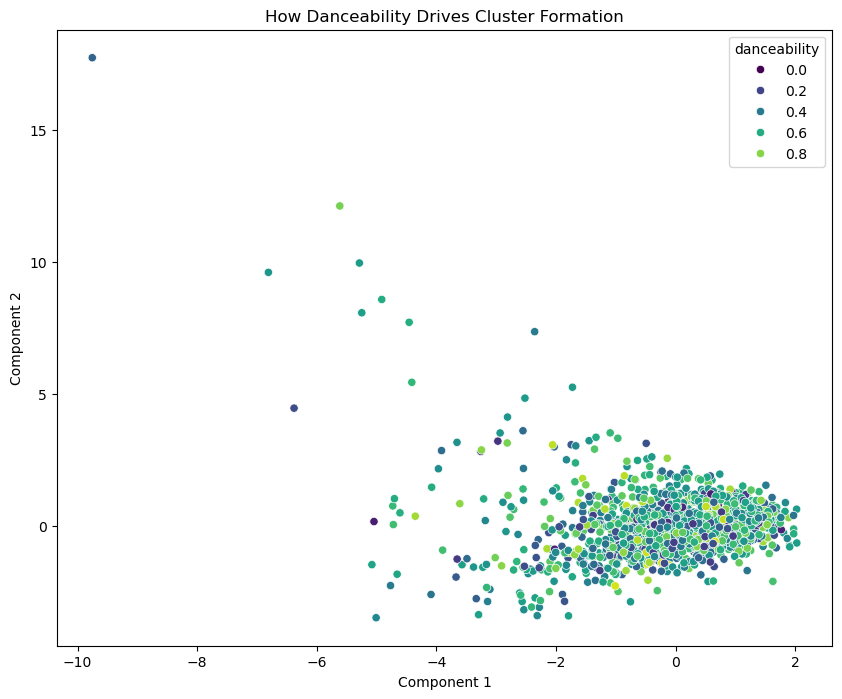

In [222]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=plot_df['Component 1'],
    y=plot_df['Component 2'],
    hue=X_top['danceability'],  # Try different features
    palette='viridis'
)
plt.title("How Danceability Drives Cluster Formation")
plt.show()


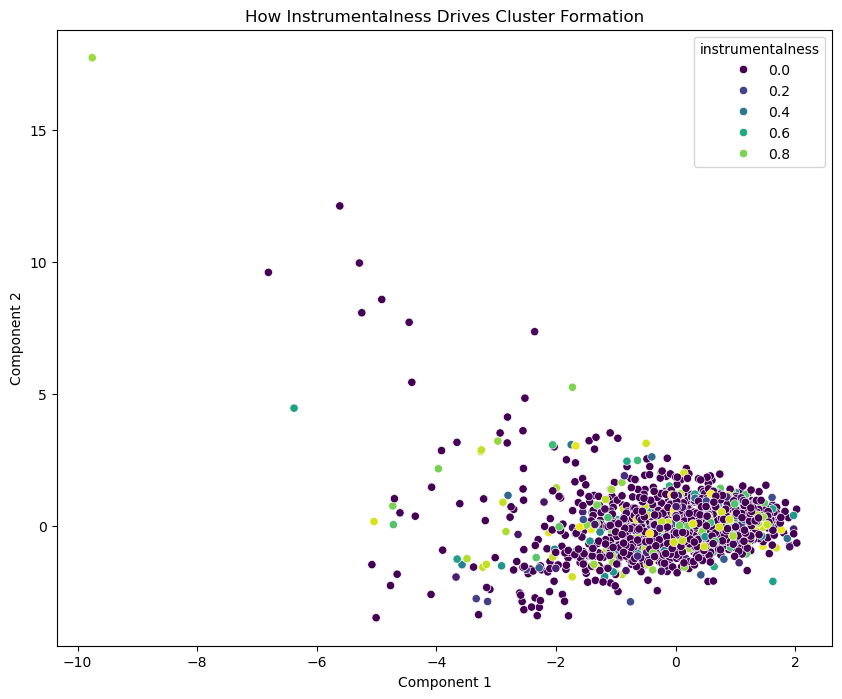

In [224]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=plot_df['Component 1'],
    y=plot_df['Component 2'],
    hue=X_top['instrumentalness'],  # Try different features
    palette='viridis'
)
plt.title("How Instrumentalness Drives Cluster Formation")
plt.show()


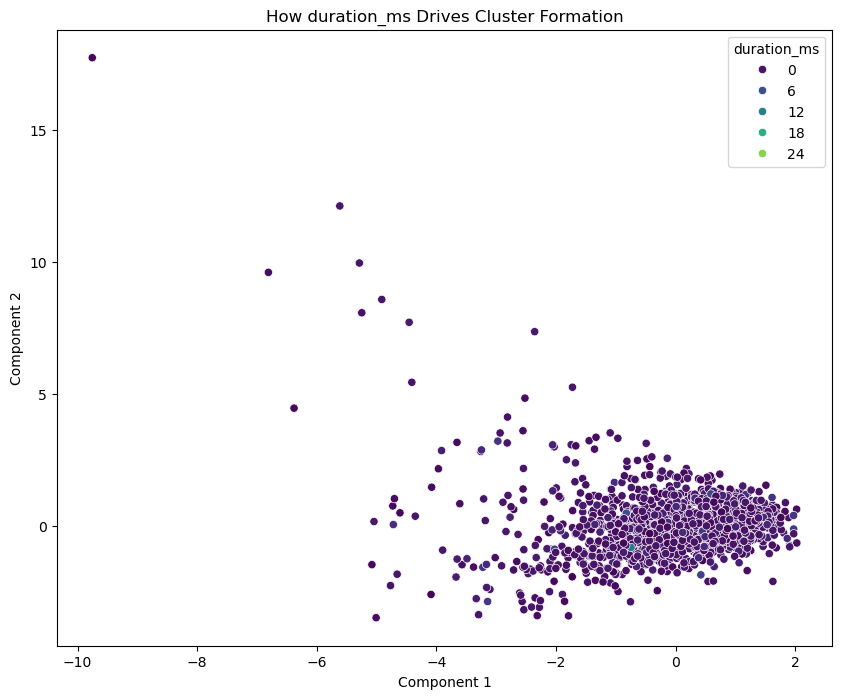

In [228]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=plot_df['Component 1'],
    y=plot_df['Component 2'],
    hue=X_top['duration_ms'],  # Try different features
    palette='viridis'
)
plt.title("How duration_ms Drives Cluster Formation")
plt.show()


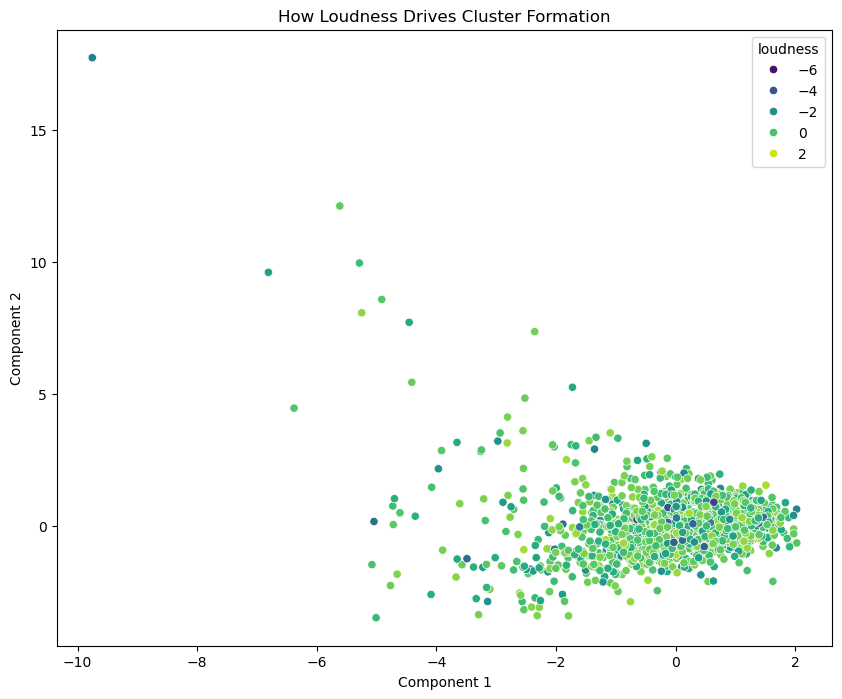

In [230]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=plot_df['Component 1'],
    y=plot_df['Component 2'],
    hue=X_top['loudness'],  # Try different features
    palette='viridis'
)
plt.title("How Loudness Drives Cluster Formation")
plt.show()


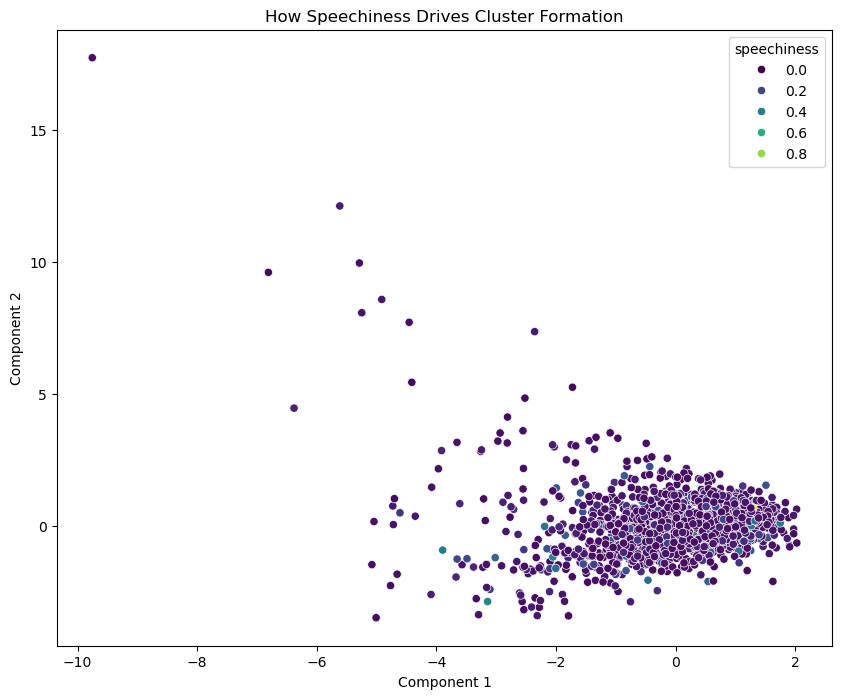

In [232]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=plot_df['Component 1'],
    y=plot_df['Component 2'],
    hue=X_top['speechiness'],  # Try different features
    palette='viridis'
)
plt.title("How Speechiness Drives Cluster Formation")
plt.show()


#### Table showing pairwise SHAP interaction strengths, including both raw interaction magnitude and normalized strength relative to individual feature effects.

In [250]:
# Calculate interaction summary and interaction strengths
interaction_summary = np.abs(shap_interaction_values).mean(0)
np.fill_diagonal(interaction_summary, 0)
top_features = X_top.columns.tolist()

# Flatten to pairwise DataFrame
summary_df = pd.DataFrame(interaction_summary, index=top_features, columns=top_features)
summary_df = summary_df.unstack().reset_index()
summary_df.columns = ['Feature1', 'Feature2', 'MeanInteraction']
summary_df = summary_df[summary_df['Feature1'] != summary_df['Feature2']]
summary_df[['F1', 'F2']] = summary_df[['Feature1', 'Feature2']].apply(sorted, axis=1, result_type='expand')
summary_df = summary_df.drop_duplicates(subset=['F1', 'F2']).drop(columns=['F1', 'F2'])

# Normalized interaction strengths
from itertools import combinations
interaction_strengths = []
for i, j in combinations(range(len(top_features)), 2):
    feat1, feat2 = top_features[i], top_features[j]
    interaction_matrix = np.abs(shap_interaction_values[:,i,j]).mean()
    main_i = np.abs(shap_interaction_values[:,i,i]).mean()
    main_j = np.abs(shap_interaction_values[:,j,j]).mean()
    interaction_strengths.append({
        'Feature1': feat1,
        'Feature2': feat2,
        'NormalizedStrength': interaction_matrix / (main_i + main_j),
        'AbsoluteInteraction': interaction_matrix
    })

strength_df = pd.DataFrame(interaction_strengths)

# Merge both on Feature1 + Feature2
combined_df = pd.merge(summary_df, strength_df, on=['Feature1', 'Feature2'])
combined_df = combined_df.sort_values("NormalizedStrength", ascending=False)

# Show top 10
combined_df.head(10)


Feature1      Feature2  MeanInteraction  NormalizedStrength  \
14            energy       valence         0.064559            0.194599   
21          loudness       valence         0.037767            0.159108   
42           valence   duration_ms         0.045647            0.132995   
37      acousticness   duration_ms         0.086946            0.124849   
18          loudness   speechiness         0.047780            0.112311   
9             energy      loudness         0.038410            0.103725   
39  instrumentalness       valence         0.086349            0.090146   
4       danceability  acousticness         0.071027            0.080473   
36      acousticness       valence         0.044405            0.080443   
11            energy   speechiness         0.041241            0.079336   

    AbsoluteInteraction  
14             0.064559  
21             0.037767  
42             0.045647  
37             0.086946  
18             0.047780  
9              0.038410  
39             0.086349  
4              0.071027  
36             0.044405  
11             0.041241

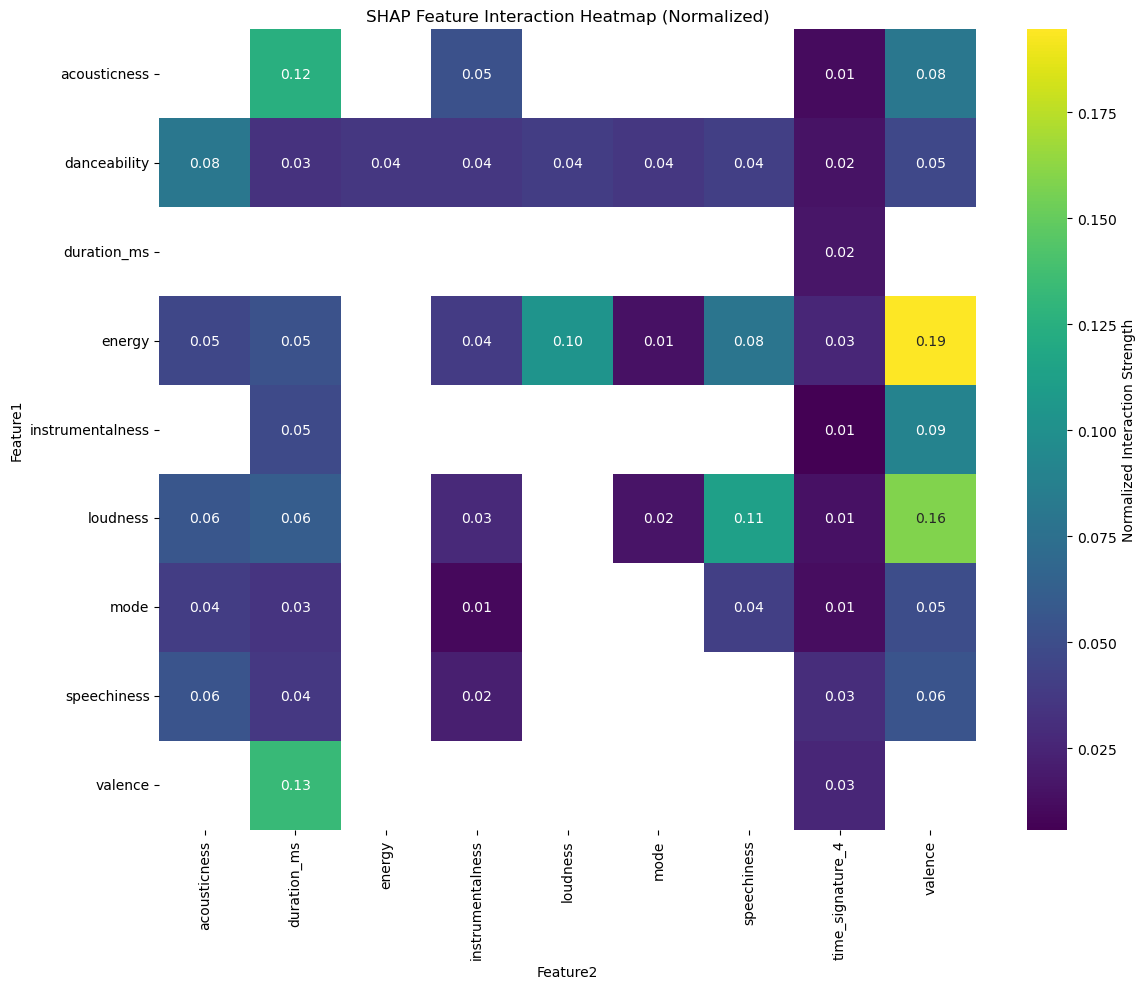

In [253]:
# Visualize Normalized Interaction Strengths with a heatmap

# Pivot for heatmap
heatmap_data = combined_df.pivot(index="Feature1", columns="Feature2", values="NormalizedStrength")

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={'label': 'Normalized Interaction Strength'}
)
plt.title("SHAP Feature Interaction Heatmap (Normalized)")
plt.tight_layout()
plt.show()


#### Calculate mean interaction strengths etc for filtering feature interactions

In [262]:
# Since strongest interaction is only 0.195, create filter based on mean interaction strength
# Calculate Key Statistics
mean_strength = interaction_df['Interaction Strength'].mean()
median_strength = interaction_df['Interaction Strength'].median()
mean_absolute = interaction_df['Absolute Interaction'].mean()

print(f"Mean Interaction Strength: {mean_strength:.3f}")
print(f"Median Interaction Strength: {median_strength:.3f}") 
print(f"Mean Absolute Interaction: {mean_absolute:.3f}")

Mean Interaction Strength: 0.052
Median Interaction Strength: 0.039
Mean Absolute Interaction: 0.029


In [257]:
# Filter Interactions Using Percentiles
# Get top 25% strongest interactions
threshold = interaction_df['Interaction Strength'].quantile(0.75)
strong_interactions = interaction_df[interaction_df['Interaction Strength'] >= threshold]

print(f"Top 25% interactions (threshold = {threshold:.3f}):")
print(strong_interactions.sort_values('Interaction Strength', ascending=False))

Top 25% interactions (threshold = 0.056):
           Feature 1     Feature 2  Interaction Strength  Absolute Interaction
14            energy       valence              0.194599              0.064559
21          loudness       valence              0.159108              0.037767
42           valence   duration_ms              0.132995              0.045647
37      acousticness   duration_ms              0.124849              0.086946
18          loudness   speechiness              0.112311              0.047780
9             energy      loudness              0.103725              0.038410
39  instrumentalness       valence              0.090146              0.086349
4       danceability  acousticness              0.080473              0.071027
36      acousticness       valence              0.080443              0.044405
11            energy   speechiness              0.079336              0.041241
22          loudness   duration_ms              0.060666              0.023161
19        

In [259]:
# Filter by Mean Absolute Interaction
above_mean_abs = interaction_df[interaction_df['Absolute Interaction'] > mean_absolute]
print(f"\nInteractions above mean absolute value ({mean_absolute:.3f}):")
print(above_mean_abs.sort_values('Absolute Interaction', ascending=False))


Interactions above mean absolute value (0.029):
           Feature 1         Feature 2  Interaction Strength  \
37      acousticness       duration_ms              0.124849   
39  instrumentalness           valence              0.090146   
4       danceability      acousticness              0.080473   
35      acousticness  instrumentalness              0.052503   
14            energy           valence              0.194599   
40  instrumentalness       duration_ms              0.048071   
18          loudness       speechiness              0.112311   
5       danceability  instrumentalness              0.035534   
42           valence       duration_ms              0.132995   
36      acousticness           valence              0.080443   
13            energy  instrumentalness              0.038824   
11            energy       speechiness              0.079336   
30       speechiness      acousticness              0.055050   
9             energy          loudness              0.1

#### Run the model using PCA... terrible results... maybe I've set this up incorrectly... maybe it's not linear

In [268]:
# Copy existing original X_train / X_test if already defined
X_train_interact = X_train.copy()
X_test_interact = X_test.copy()

# Add interaction terms to both sets
for _, row in top_interactions.iterrows():
    f1, f2 = row['Feature 1'], row['Feature 2']
    X_train_interact[f"{f1}_x_{f2}"] = X_train_interact[f1] * X_train_interact[f2]
    X_test_interact[f"{f1}_x_{f2}"] = X_test_interact[f1] * X_test_interact[f2]

# Fit PCA on training set, transform both sets
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_interact)
X_test_pca = pca.transform(X_test_interact)

# Train and evaluate PCA-based XGBoost
pca_model = XGBClassifier(
    eval_metric='logloss',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    gamma=0.1
)

pca_model.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = pca_model.predict(X_test_pca)
y_proba_pca = pca_model.predict_proba(X_test_pca)[:, 1]

print("PCA XGBoost Accuracy:", accuracy_score(y_test, y_pred_pca))
print("PCA XGBoost AUC:", roc_auc_score(y_test, y_proba_pca))
print("Classification Report:\n", classification_report(y_test, y_pred_pca))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_pca))


PCA XGBoost Accuracy: 0.7496301775147929
PCA XGBoost AUC: 0.8193278652745051
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.65      0.73      4164
           1       0.70      0.85      0.77      3948

    accuracy                           0.75      8112
   macro avg       0.76      0.75      0.75      8112
weighted avg       0.76      0.75      0.75      8112

Confusion Matrix:
 [[2706 1458]
 [ 573 3375]]


In [367]:
# Append PCA model results to the list
model_results.append({
    "Model": "PCA XGBoost",
    "Train Accuracy": np.nan,
    "Test Accuracy": accuracy_score(y_test, y_pred_pca),
    "Accuracy Gap": np.nan,
    "ROC AUC": roc_auc_score(y_test, y_proba_pca),
    "Precision": precision_score(y_test, y_pred_pca),
    "Recall": recall_score(y_test, y_pred_pca),
    "F1 Score": f1_score(y_test, y_pred_pca)
})


# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Re-sort AFTER adding the custom model
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False)

# Display the updated sorted DataFrame
print("\nModel Performance Comparison:")
display(
    results_df_sorted.style
    .highlight_max(subset=[col for col in results_df.columns if col not in ["Model", "Accuracy Gap"]], axis=0, color='lightgreen')
    .highlight_min(subset=["Accuracy Gap"], axis=0, color='lightgreen')
    .format({col: "{:.1%}" for col in results_df.columns if col != "Model"}, na_rep='–')
)



Model Performance Comparison:


#### Side-by-side code setup to test both Kernel PCA (better for non-linear relationships) and TruncatedSVD (better for sparse/high dimension data)

In [276]:
from sklearn.decomposition import KernelPCA, TruncatedSVD
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Common XGBoost settings (can adjust/tune if needed)
xgb_params = {
    "eval_metric": "logloss",
    "max_depth": 5,
    "learning_rate": 0.05,
    "n_estimators": 200,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 1,
    "gamma": 0.1,
    "random_state": 42
}


# Kernel PCA (non-linear dimensionality reduction)
kpca = KernelPCA(n_components=30, kernel='rbf', random_state=42)
X_train_kpca = kpca.fit_transform(X_train_interact)
X_test_kpca = kpca.transform(X_test_interact)

# Train model
kpca_model = XGBClassifier(**xgb_params)
kpca_model.fit(X_train_kpca, y_train)

# Predict and evaluate
y_pred_kpca = kpca_model.predict(X_test_kpca)
y_proba_kpca = kpca_model.predict_proba(X_test_kpca)[:, 1]

print("Kernel PCA XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_kpca))
print("ROC AUC:", roc_auc_score(y_test, y_proba_kpca))
print("Classification Report:\n", classification_report(y_test, y_pred_kpca))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_kpca))


Kernel PCA XGBoost Results:
Accuracy: 0.7443293885601578
ROC AUC: 0.8207490788025309
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.66      0.73      4164
           1       0.70      0.84      0.76      3948

    accuracy                           0.74      8112
   macro avg       0.75      0.75      0.74      8112
weighted avg       0.76      0.74      0.74      8112

Confusion Matrix:
 [[2734 1430]
 [ 644 3304]]


In [281]:
# Truncated SVD (linear, efficient for sparse/high-dim data)
svd = TruncatedSVD(n_components=30, random_state=42)
X_train_svd = svd.fit_transform(X_train_interact)
X_test_svd = svd.transform(X_test_interact)

# Train model
svd_model = XGBClassifier(**xgb_params)
svd_model.fit(X_train_svd, y_train)

# Predict and evaluate
y_pred_svd = svd_model.predict(X_test_svd)
y_proba_svd = svd_model.predict_proba(X_test_svd)[:, 1]

print("\nTruncated SVD XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svd))
print("ROC AUC:", roc_auc_score(y_test, y_proba_svd))
print("Classification Report:\n", classification_report(y_test, y_pred_svd))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svd))



Truncated SVD XGBoost Results:
Accuracy: 0.7612179487179487
ROC AUC: 0.8416076258410246
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.68      0.75      4164
           1       0.72      0.84      0.77      3948

    accuracy                           0.76      8112
   macro avg       0.77      0.76      0.76      8112
weighted avg       0.77      0.76      0.76      8112

Confusion Matrix:
 [[2847 1317]
 [ 620 3328]]


In [369]:
# Append Kernel PCA model
model_results.append({
    "Model": "Kernel PCA Model",
    "Train Accuracy": np.nan,
    "Test Accuracy": accuracy_score(y_test, y_pred_kpca),
    "Accuracy Gap": np.nan,
    "ROC AUC": roc_auc_score(y_test, y_proba_kpca),
    "Precision": precision_score(y_test, y_pred_kpca),
    "Recall": recall_score(y_test, y_pred_kpca),
    "F1 Score": f1_score(y_test, y_pred_kpca)
})

# Append Truncated SVD model
model_results.append({
    "Model": "Truncated SVD Model",
    "Train Accuracy": np.nan,
    "Test Accuracy": accuracy_score(y_test, y_pred_svd),
    "Accuracy Gap": np.nan,
    "ROC AUC": roc_auc_score(y_test, y_proba_svd),
    "Precision": precision_score(y_test, y_pred_svd),
    "Recall": recall_score(y_test, y_pred_svd),
    "F1 Score": f1_score(y_test, y_pred_svd)
})

# Convert to DataFrame and enforce numeric columns
results_df = pd.DataFrame(model_results)

# Re-sort AFTER adding the custom model
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False)

# Display the updated sorted DataFrame
print("\nModel Performance Comparison:")
display(
    results_df_sorted.style
    .highlight_max(subset=[col for col in results_df.columns if col not in ["Model", "Accuracy Gap"]], axis=0, color='lightgreen')
    .highlight_min(subset=["Accuracy Gap"], axis=0, color='lightgreen')
    .format({col: "{:.1%}" for col in results_df.columns if col != "Model"}, na_rep='–')
)



Model Performance Comparison:
